In [2]:
import pandas as pd
import numpy as np
import pypsa
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

In [87]:
def calc_demand(n):
    '''in TWH'''
    loads = n.loads_t.p.filter(regex='_AC').sum().sum() *3 / 1e6
    return loads
def calc_h2_demand(n):
    '''in TWH'''
    return n.loads_t.p.filter(like='H2').multiply(n.snapshot_weightings.iloc[0,0]).divide(1e6).sum().sum()

def calc_ac_demand(n):
    '''in TWH'''
    return n.loads_t.p.filter(regex='_AC$').multiply(n.snapshot_weightings.iloc[0,0]).divide(1e6).sum().sum()

def calc_wap_elec(n, agg=True):
    '''Takes a solved sector-coupled PyPSA network and returns electricity price per MWh for system or single nodes'''
    d_elec = n.loads_t['p'].filter(regex='AC$') #Amounts of electricity consumed

    weightings = pd.DataFrame(
        np.outer(n.snapshot_weightings["generators"], [1.0] * len(d_elec.T)),
        index=n.snapshots,
        columns=d_elec.columns,
    )
    d_elec = d_elec * weightings
    marginal_prices = n.buses_t.marginal_price.loc[:, d_elec.columns] #Marginal elec prices at nodes
    d_costs = (d_elec * marginal_prices).sum() #Product of demand and prices yields average total value of electricity consumed at nodes
    if agg:
        return d_costs.sum() / d_elec.sum().sum()
    else:
        return d_costs / d_elec.sum()

def calc_wap_h2(n, agg=True):
    '''Takes a solved sector-coupled PyPSA network and outputs specific productio costs for one kg exported hydrogen'''
    d_h2 = n.loads_t['p'].filter(like='H2').drop('H2 export load', axis=1) #Amounts of H2 demanded at export node

    weightings = pd.DataFrame(
        np.outer(n.snapshot_weightings["generators"], [1.0] * len(d_h2.T)),
        index=n.snapshots,
        columns=d_h2.columns,
    )
    d_h2 = d_h2 * weightings
    d_h2.columns = n.loads.loc[d_h2.columns, 'bus']
    d_h2 = d_h2.groupby(d_h2.columns, axis=1).sum()

    marginal_prices = n.buses_t.marginal_price.loc[:, d_h2.columns] #Marginal H2 prices at export nodes
    h2_costs = (d_h2 * marginal_prices).sum()
    
    if agg:
        return h2_costs.sum() / d_h2.sum().sum() * 33.3 / 1000
    else:
        return h2_costs / d_h2.sum() * 33.3 / 1000

def calc_curtailment(n):
    '''in percent'''
    gen_ts = n.generators_t
    max_gen = gen_ts.p_max_pu * 3
    gen = gen_ts.p[max_gen.columns] * 3
    p_nom_max = n.generators.loc[max_gen.columns].p_nom_opt

    curtailment = ((p_nom_max * max_gen) - gen)
    agg_curtailment =  curtailment.sum().sum() / 1e6

    return agg_curtailment / (gen.sum().sum() / 1e6) * 100

def calc_wap_h2_exp(n):
    '''Takes a solved sector-coupled PyPSA network and outputs specific productio costs for one kg exported hydrogen'''
    h2_prod_ex = n.links_t['p0'].filter(like='H2 export') #Amounts of H2 produced and provided for export

    h2_prod_ex.columns = h2_prod_ex.columns.str.strip(' export') #Modify column names to match with MP dataframe
    weightings = pd.DataFrame(
        np.outer(n.snapshot_weightings["generators"], [1.0] * len(h2_prod_ex.T)),
        index=n.snapshots,
        columns=h2_prod_ex.columns,
    )
    h2_prod_ex = h2_prod_ex * weightings
    marginal_prices = n.buses_t.marginal_price.loc[:, h2_prod_ex.columns] #Marginal H2 prices at export nodes
    prod_costs = (h2_prod_ex * marginal_prices).sum().sum() #Product of production ampunts and prices yields total production costs for each export node
    spec_prod_costs = prod_costs / h2_prod_ex.sum().sum() # Division by total nodal production amount yields specific production costs of hydrogen for each export node
    spec_prod_costs = spec_prod_costs * 33.3 / 1000 #Calculate costs per kg assuming 1 kg H2 equals 33.3 KWh
    return spec_prod_costs

def calc_export_shares(n, absolute=True):
    '''absolute or relative'''
    ex_qs = n.links_t.p0.filter(like='H2 export').sum() * 3
    if absolute==False:
        ex_qs_rel = ex_qs / ex_qs.sum()
        return ex_qs_rel
    else:
        return ex_qs / 1e6

def calc_elec_capa(n):
    '''in GW'''
    return n.links.filter(like='Electrolysis', axis=0).p_nom_opt.sum() / 1e3

def calc_solar_capa(n):
    '''in GW'''
    return n.generators.loc[n.generators.carrier == 'solar', 'p_nom_opt'].sum() / 1e3

def calc_onwind_capa(n):
    '''in GW'''
    return n.generators.loc[n.generators.carrier.str.contains('onwind'), 'p_nom_opt'].sum() / 1e3

def calc_uhs_capa(n):
    '''in TWH'''
    return n.stores.filter(like='H2 Store', axis=0).e_nom_opt.sum() / 1e6

def calc_elec_cf(n):
    '''''Calculated capacity factor for electrolysis'''''
    elec_cap = n.links.filter(like='Electrolysis', axis=0).p_nom_opt.sum() *8760
    elec_output = n.links_t.p0.filter(like='Electrolysis').sum().sum() * n.snapshot_weightings.iloc[0,0]

    return elec_output / elec_cap

def calc_local_h2_share(n):
    links = n.links
    links_t = n.links_t

    exp_h2_links = n.links.loc[links.bus1 == 'H2 export bus']
    exp_h2_links_ts = links_t.p0[exp_h2_links.index] * n.snapshot_weightings.iloc[0,0] / 1e3
    exp_h2_links_exp = exp_h2_links_ts.sum().sum()

    exp_h2_links = n.links.loc[links.bus1 == 'H2 export bus'].index.str.rstrip('export') + 'Electrolysis'
    exp_h2_links_prod_ts = links_t.p1[exp_h2_links] * -n.snapshot_weightings.iloc[0,0] / 1e3
    exp_h2_links_prod = exp_h2_links_prod_ts.sum().sum()

    return  exp_h2_links_exp / exp_h2_links_prod

def calc_batt_capa(n):
    '''in TWh'''
    return n.stores.filter(like='battery', axis=0).e_nom_opt.sum() / 1e6

def calc_batt_charge_capa(n):
    '''in GW'''
    return n.links.filter(regex='battery charge', axis=0).p_nom_opt.sum() / 1e3

def calc_batt_discharge_capa(n):
    '''in GW'''
    return n.links.filter(regex='battery discharge', axis=0).p_nom_opt.sum() / 1e3

def calc_line_capa(n):
    return (n.lines.s_nom_opt * n.lines.length).sum()

# Parse networks and creates summary table

1. Choose runnames in /pypsa-earth-sec/results/
2. Adapt configuration parameters: clusters, interest rate, line expansion
3. Adapt export quantities inside of loop
4. Adapt path inside of loop

In [88]:
run = {2030:'NA_2030_daily_15092023', 2050:'NA_2050_daily_15092023'}

clusters = {'BS': {2030:60, 2050:255}, 'AP':{2030:65, 2050:256}, 'NZ':{2030:67, 2050:257}}
i_rate = {'BS': {2030:0.097, 2050:0.175}, 'AP':{2030:0.082, 2050:0.086}, 'NZ':{2030:0.076, 2050:0.045}}
ll = {'BS': {2030:'c1.0', 2050:'v1.05'}, 'AP':{2030:'c1.0', 2050:'v1.1'}, 'NZ':{2030:'c1.0', 2050:'v1.25'}}

summary = pd.DataFrame()
networks = {}
for year in [2030]:
    networks[year] = {}
    for s in ['BS', 'AP', 'NZ']:
        networks[year][s] = {}
        line_exp = ll[s][year]
        system_costs_no_exports = 0
        if year == 2030:
            ex_quantities = [0, 1, 10, 50, 200, 538]
        else:
            ex_quantities = [0, 10, 100, 500, 1000, 2000, 3000]
        for export in ex_quantities:
            n_s_y_e = pypsa.Network("/nfs/home/raj08555/Git-hypat/pypsa-earth-sec/results/{}/postnetworks/elec_s_{}_ec_l{}_Co2L_3H_{}_{}_{}_{}export.nc".format(run[year], clusters[s][year], line_exp,year, i_rate[s][year],s, export))
            networks[year][s][export] = n_s_y_e
            system_costs_e = n_s_y_e.objective
            system_costs_cons_e = n_s_y_e.objective + n_s_y_e.objective_constant
            if export == 0:
                system_costs_no_exports= system_costs_e 
                system_costs_no_exports_cons = system_costs_cons_e

            hydrogen_costs = (system_costs_e - system_costs_no_exports) / (export*1e9) * 33.3
            hydrogen_costs_corr = (system_costs_cons_e - system_costs_no_exports_cons) / (export*1e9) * 33.3
            elec_wap = calc_wap_elec(n_s_y_e)
            h2_wap = calc_wap_h2(n_s_y_e)
            demand = calc_demand(n_s_y_e) + export
            ac_demand = calc_ac_demand(n_s_y_e)
            h2_demand = calc_h2_demand(n_s_y_e)
            curtailment = calc_curtailment(n_s_y_e)

            exp_ports = ['NAM19_AC H2 export', 'NAM12_AC H2 export']
            if export == 0:
                hydrogen_wap_exp = 0
                exp_shares = pd.Series(np.zeros(2), index=exp_ports)
            # if export == 1:
            #     hydrogen_wap_exp = calc_wap_h2_exp(n_s_y_e)
            #     s = [calc_export_shares(n_s_y_e), 0]
            #     exp_shares = pd.Series(s)
            else:
                hydrogen_wap_exp = calc_wap_h2_exp(n_s_y_e)
                exp_shares = calc_export_shares(n_s_y_e)
            electro_capa = calc_elec_capa(n_s_y_e)
            solar_capa = calc_solar_capa(n_s_y_e)
            onwind_capa = calc_onwind_capa(n_s_y_e)
            elec_cf = calc_elec_cf(n_s_y_e)
            uhs_capa = calc_uhs_capa(n_s_y_e)
            batt_capa = calc_batt_capa(n_s_y_e)
            batt_capa_ch = calc_batt_charge_capa(n_s_y_e)
            batt_capa_disch = calc_batt_discharge_capa(n_s_y_e)
            local_h2_share = round(calc_local_h2_share(n_s_y_e) * 100, 2)
            line_capa = calc_line_capa(n_s_y_e) / 1e6
        

            nc_n = pd.DataFrame(data={'year':[year],
            'scenario':[s],
            'export_quantity':[export],
            'system_costs':[system_costs_e],
            'system_costs_corr':[system_costs_cons_e],
            'demand':demand,
            'costs-demand-ratio':[system_costs_cons_e / demand / 1e6],
            'exp_h2_cost_norm':[hydrogen_costs],
            'exp_h2_cost_norm_corr':[hydrogen_costs_corr],
            'exp_h2_cost_mp':[hydrogen_wap_exp],
            'electrolyzer_capacity':[electro_capa],
            'electrolyzer_cf':[elec_cf],
            'solar_capacity':[solar_capa],
            'onwind_capacity':[onwind_capa],
            'uhs_capa':[uhs_capa],
            'batt_capa':[batt_capa],
            'batt_capa_ch':[batt_capa_ch],
            'batt_capa_disch':[batt_capa_disch],
            'ac_demand':[ac_demand],
            'elec_mp':[elec_wap],
            'h2_demand':[h2_demand],
            'h2_mp':[h2_wap],
            'curtailment':curtailment,
            exp_ports[0]:exp_shares[exp_ports[0]],
            exp_ports[1]:(export-exp_shares[exp_ports[0]]).round(2),
            'local_h2_prod_exp':[local_h2_share],
            'line_capa':[line_capa]
            })
            summary = pd.concat([summary, nc_n]).fillna(0)

summary

INFO:pypsa.io:Imported network elec_s_60_ec_lc1.0_Co2L_3H_2030_0.097_BS_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
/tmp/ipykernel_686854/3653125870.py:28: RuntimeWarning: invalid value encountered in double_scalars
  hydrogen_costs = (system_costs_e - system_costs_no_exports) / (export*1e9) * 33.3
/tmp/ipykernel_686854/3653125870.py:29: RuntimeWarning: invalid value encountered in double_scalars
  hydrogen_costs_corr = (system_costs_cons_e - system_costs_no_exports_cons) / (export*1e9) * 33.3
INFO:pypsa.io:Imported network elec_s_60_ec_lc1.0_Co2L_3H_2030_0.097_BS_1export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_60_ec_lc1.0_Co2L_3H_2030_0.097_BS_10export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_60_ec_lc1.0_Co2L_3H_2030_0.097_BS_50export.nc has buses, carriers, generators, global_

,year,scenario,export_quantity,system_costs,system_costs_corr,demand,costs-demand-ratio,exp_h2_cost_norm,exp_h2_cost_norm_corr,exp_h2_cost_mp,...,batt_capa_disch,ac_demand,elec_mp,h2_demand,h2_mp,curtailment,NAM19_AC H2 export,NAM12_AC H2 export,local_h2_prod_exp,line_capa
0,2030,BS,0,1.220050e+09,1.228434e+09,29.025593,42.322455,0.000000,0.000000,0.000000,...,0.492547,0.88,60.584037,1.341033,3.156982,5.222993,0.000000,0.00,0.00,11.256813
0,2030,BS,1,1.312183e+09,1.320568e+09,30.025593,43.981401,3.068038,3.068038,2.605282,...,0.458965,0.88,57.429492,2.341033,3.141109,4.024285,1.000000,-0.00,93.92,11.256813
0,2030,BS,10,2.028909e+09,2.037294e+09,39.025593,52.204058,2.693504,2.693504,2.751156,...,0.305693,0.88,40.952791,11.341033,3.219430,12.247604,9.723066,0.28,99.24,11.256813
0,2030,BS,50,5.648151e+09,5.656536e+09,79.025593,71.578528,2.949115,2.949115,3.093255,...,0.364374,0.88,41.032453,51.341033,3.185929,22.437740,14.779315,35.22,99.85,11.256813
0,2030,BS,200,1.963226e+10,1.964065e+10,229.025593,85.757426,3.065633,3.065633,3.107185,...,0.208304,0.88,36.450261,201.341033,3.183847,27.766964,15.982610,184.02,99.96,11.256813
0,2030,BS,538,7.042757e+10,7.043596e+10,567.025593,124.220068,4.283663,4.283663,5.681700,...,1.416465,0.88,20.808430,539.341033,3.025712,26.290178,42.040744,495.96,99.99,11.256813
0,2030,AP,0,1.335726e+09,1.344364e+09,29.025593,46.316489,0.000000,0.000000,0.000000,...,0.647470,0.88,59.199052,1.341033,3.107866,7.400950,0.000000,0.00,0.00,11.256813
0,2030,AP,1,1.413229e+09,1.421866e+09,30.025593,47.355138,2.580835,2.580835,2.619944,...,0.632886,0.88,53.835765,2.341033,3.131738,8.174755,1.000000,0.00,93.93,11.256813
0,2030,AP,10,2.139469e+09,2.148106e+09,39.025593,55.043525,2.676463,2.676463,2.722500,...,0.441578,0.88,45.581250,11.341033,3.171241,12.972537,9.682201,0.32,99.24,11.256813
0,2030,AP,50,5.729928e+09,5.738566e+09,79.025593,72.616548,2.926539,2.926539,3.057392,...,0.238948,0.88,37.133237,51.341033,3.119870,21.655407,14.954868,35.05,99.85,11.256813


### Clean summary table of one scenario for one particular time horizon

Choose year (2030/2050) and scenario (BS/AP/NZ)

In [89]:
Year = 2030
Scenario = "AP"
summary_clean = summary.loc[(summary.year == Year) & (summary.scenario == Scenario)]

cols = ['year', 'scenario', 'export_quantity', 'demand', 'system_costs_corr', 'costs-demand-ratio','elec_mp', 'h2_mp', 'curtailment', 
       'electrolyzer_capacity',
        'solar_capacity', 'onwind_capacity', 'uhs_capa', 'batt_capa',
       'batt_capa_ch', 'batt_capa_disch',
       'NAM19_AC H2 export', 'NAM12_AC H2 export', 'ac_demand', 'h2_demand']
summary_clean = summary_clean[cols]

better_names = {
    'export_quantity':'Export quantity [TWh]', 'system_costs_corr':'System costs [B€]', 'demand':'Total demand [TWh]', 
       'costs-demand-ratio':'Normalized system costs [€/TWh]', 'elec_mp':'Electricity WAP [€/MWh]', 'h2_mp':'H2 WAP [€/kg]', 
       'curtailment':'Curtailment [% of non-dispatchable generation]', 'electrolyzer_capacity':'Electrolysis [GW]','solar_capacity':'Solar PV [GW]',
       'onwind_capacity':'Wind onshore [GW]','uhs_capa':'UHS [GWh]', 'batt_capa':'Battery storage [GWh]', 'batt_capa_ch':'Battery charger [GW]', 'batt_capa_disch':'Battery discharger [GW]',
       'NAM19_AC H2 export':'Export via WB [TWh]','NAM12_AC H2 export':'Export via LB [TWh]',
        'ac_demand':'Domestic electricity demand','h2_demand':'Overall H2 demand',
}

summary_clean.system_costs_corr = summary_clean.system_costs_corr / 1e9
summary_clean.rename(better_names, axis=1, inplace=True)
summary_clean.to_csv('../outputs/summary_{0}_{1}.csv'.format(Year, Scenario), index=False, encoding='utf-8-sig')
summary_clean

,year,scenario,Export quantity [TWh],Total demand [TWh],System costs [B€],Normalized system costs [€/TWh],Electricity WAP [€/MWh],H2 WAP [€/kg],Curtailment [% of non-dispatchable generation],Electrolysis [GW],Solar PV [GW],Wind onshore [GW],UHS [GWh],Battery storage [GWh],Battery charger [GW],Battery discharger [GW],Export via WB [TWh],Export via LB [TWh],Domestic electricity demand,Overall H2 demand
0,2030,AP,0,29.025593,1.344364,46.316489,59.199052,3.107866,7.400950,0.602275,2.903583,0.048410,0.001838,0.004148,0.634388,0.647470,0.000000,0.00,0.88,1.341033
0,2030,AP,1,30.025593,1.421866,47.355138,53.835765,3.131738,8.174755,1.112564,3.818358,0.068121,0.001837,0.004064,0.620100,0.632886,1.000000,0.00,0.88,2.341033
0,2030,AP,10,39.025593,2.148106,55.043525,45.581250,3.171241,12.972537,5.683761,11.872570,0.434139,0.001837,0.002963,0.432657,0.441578,9.682201,0.32,0.88,11.341033
0,2030,AP,50,79.025593,5.738566,72.616548,37.133237,3.119870,21.655407,26.281630,50.033950,1.587360,0.002695,0.001795,0.234120,0.238948,14.954868,35.05,0.88,51.341033
0,2030,AP,200,229.025593,19.564727,85.425943,33.000962,3.122252,27.783219,105.755219,202.084481,2.396068,0.002301,0.001486,0.181487,0.185229,15.796331,184.20,0.88,201.341033
0,2030,AP,538,567.025593,70.658341,124.612260,18.475746,3.003375,24.311015,211.208207,354.624650,52.686175,0.001731,0.015678,1.483652,1.514246,41.960859,496.04,0.88,539.341033


# System cost breakdown into investments and dispatch costs

Choose networks to be compared in first cell

In [90]:
n0 = networks[2030]['AP'][0]
n1 = networks[2030]['AP'][200]

In [91]:
tech_colors={
  0: "black",
  " oil Store": "yellow",
  "SMR CC": "darkblue",
  "csp": "gold",
  "gas for industry CC": "brown",
  "process emissions CC": "gray",
  "CO2 pipeline": "gray",
  "onwind": "dodgerblue",
  "onwind2": "dodgerblue",
  "onshore wind": "#235ebc",
  "offwind": "#6895dd",
  "offwind2": "#6895dd",
  "offshore wind": "#6895dd",
  "offwind-ac": "c",
  "offshore wind (AC)": "#6895dd",
  "offwind-dc": "#74c6f2",
  "offshore wind (DC)": "#74c6f2",
  "wave": '#004444',
  "hydro": 'midnightblue',
  "hydro reservoir": '#3B5323',
  "ror": '#78AB46',
  "run of river": '#78AB46',
  "hydroelectricity": 'midnightblue',
  "solar": "orange",
  "solar PV": "#f9d002",
  "solar thermal": "coral",
  "solar rooftop": '#ffef60',
  "OCGT": "red",
  "OCGT marginal": "sandybrown",
  "OCGT-heat": '#ee8340',
  "gas boiler": '#ee8340',
  "gas boilers": '#ee8340',
  "gas boiler marginal": '#ee8340',
  "gas-to-power/heat": 'brown',
  "gas": "brown",
  "natural gas": "brown",
  "SMR": '#4F4F2F',
  "oil": '#B5A642',
  "oil boiler": '#B5A677',
  "lines": "k",
  "transmission lines": "k",
  "H2": "magenta",
  "H2 liquefaction": "m",
  "hydrogen storage": "m",
  "battery": "slategray",
  "battery storage": "slategray",
  "home battery": '#614700',
  "home battery storage": '#614700',
  "Nuclear": "r",
  "Nuclear marginal": "r",
  "nuclear": "r",
  "uranium": "r",
  "Coal": "k",
  "coal": "saddlebrown",
  "Coal marginal": "k",
  "Lignite": "grey",
  "lignite": "grey",
  "Lignite marginal": "grey",
  "CCGT": '#ee8340',
  "CCGT marginal": '#ee8340',
  "heat pumps": '#76EE00',
  "heat pump": '#76EE00',
  "air heat pump": '#76EE00',
  "ground heat pump": '#40AA00',
  "power-to-heat": 'crimson',
  "resistive heater": "pink",
  "Sabatier": '#FF1493',
  "methanation": '#FF1493',
  "power-to-gas": 'purple',
  "electrolysis": 'purple',
  "power-to-liquid": 'darkgreen',
  "helmeth": '#7D0552',
  "DAC": 'deeppink',
  "co2 stored": '#123456',
  "CO2 sequestration": '#123456',
  "CC": "k",
  "co2": '#123456',
  "co2 vent": '#654321',
  "agriculture heat": '#D07A7A',
  "agriculture machinery oil": '#1e1e1e',
  "agriculture machinery oil emissions": '#111111',
  "agriculture electricity": '#222222',
  "solid biomass for industry co2 from atmosphere": '#654321',
  "solid biomass for industry co2 to stored": '#654321',
  "solid biomass for industry CC": '#654321',
  "gas for industry co2 to atmosphere": '#654321',
  "gas for industry co2 to stored": '#654321',
  "Fischer-Tropsch": '#44DD33',
  "kerosene for aviation": '#44DD33',
  "naphtha for industry": '#44DD33',
  "land transport oil": '#B5A642',
  "water tanks": '#BBBBBB',
  "hot water storage": '#BBBBBB',
  "hot water charging": '#BBBBBB',
  "hot water discharging": '#999999',
  # CO2 pipeline: '#999999'
  "CHP": "r",
  "CHP heat": "r",
  "CHP electric": "r",
  "PHS": "g",
  "Ambient": "k",
  "Electric load": "b",
  "Heat load": "r",
  "heat": "darkred",
  "rural heat": '#880000',
  "central heat": '#b22222',
  "decentral heat": '#800000',
  "low-temperature heat for industry": '#991111',
  "process heat": '#FF3333',
  "heat demand": "darkred",
  "electric demand": "k",
  "Li ion": "grey",
  "district heating": '#CC4E5C',
  "retrofitting": "purple",
  "building retrofitting": "purple",
  "BEV charger": "grey",
  "V2G": "grey",
  "land transport EV": "grey",
  "electricity": "steelblue",
  "gas for industry": '#333333',
  "solid biomass for industry": '#555555',
  "industry electricity": '#222222',
  "industry new electricity": '#222222',
  "process emissions to stored": '#444444',
  "process emissions to atmosphere": '#888888',
  "process emissions": 'chocolate',
  "oil emissions": '#666666',
  "industry oil emissions": '#666666',
  "land transport oil emissions": '#666666',
  "land transport fuel cell": '#AAAAAA',
  "biogas": 'springgreen',
  "solid biomass": '#DAA520',
  "today": '#D2691E',
  "shipping": '#6495ED',
  "shipping oil": "#B5A642",
  "shipping oil emissions": "#6495ED",
  "electricity distribution grid": 'y',
  "solid biomass transport": "darkseagreen",
  "biomass EOP": "green",
  "H2 for industry": "#222222",
  "H2 for shipping": "#6495ED",
  "other": "black",
  "biomass": "lawngreen",
  'system costs':'black',
  'investment costs': 'darkgrey',
  'dispatch costs': 'lightgrey',
  'CCS':'deeppink',
  'gas':'red',
  'nuclear':'yellow',
  'biomass transport':'darkseagreen',
  'process emissions':'brown',
  'transmission lines':'steelblue',
  'gas CC':'tomato',
  'biomass CC':'limegreen',
  'rail transport electricity':'grey',
  'AC':'steelblue',
  'agriculture oil':'#B5A642',
  'rail transport oil':'#B5A642',
  'residential biomass':'#DAA520',
  'residential oil':'#B5A642',
  'services oil':'#B5A642',
  'residential rural heat':'darkred',
  'services biomass':'#555555',
  'rooftop-solar':'bisque',
  'H2 storage':'purple',
  'H2 export':'lightpink',
  'conversion losses':'black',

  
  
  }

preferred_order = pd.Index(
    [
        "transmission lines",
        "hydroelectricity",
        "hydro reservoir",
        "run of river",
        "pumped hydro storage",
        "solid biomass",
        "biogas",
        "onshore wind",
        "offshore wind",
        "offshore wind (AC)",
        "offshore wind (DC)",
        "solar PV",
        "solar thermal",
        "solar",
        "building retrofitting",
        "ground heat pump",
        "air heat pump",
        "heat pump",
        "resistive heater",
        "power-to-heat",
        "gas-to-power/heat",
        "CHP",
        "OCGT",
        "gas boiler",
        "gas",
        "natural gas",
        "helmeth",
        "methanation",
        "hydrogen storage",
        "power-to-gas",
        "power-to-liquid",
        "battery storage",
        "hot water storage",
        "CO2 sequestration",
    ]
)

def rename_techs(label):
    prefix_to_remove = [
        "residential ",
        "services ",
        "urban ",
        "rural ",
        "central ",
        "decentral ",
    ]

    rename_if_contains = [
        "CHP",
        "gas boiler",
        "biogas",
        "solar thermal",
        "air heat pump",
        "ground heat pump",
        "resistive heater",
        "Fischer-Tropsch",
    ]

    rename_if_contains_dict = {
        "water tanks": "hot water storage",
        "retrofitting": "building retrofitting",
        "H2": "hydrogen storage",
        "battery": "battery storage",
        "Li ion":"battery storage",
        "BEV charge":"battery storage",
        "V2G":"battery storage",
        "CCS": "CCS",
        #"":"gas"
        #"CC": "CCS",
        "co2": "CCS",
        "CO2": "CCS",
        
    }

    rename = {
        "solar": "solar PV",
        "Sabatier": "methanation",
        "offwind": "offshore wind",
        "offwind2": "offshore wind",
        "offwind-ac": "offshore wind (AC)",
        "offwind-dc": "offshore wind (DC)",
        "onwind": "onshore wind",
        "onwind2": "onshore wind",
        "ror": "hydroelectricity",
        "hydro": "hydroelectricity",
        "PHS": "hydroelectricity",
        "co2 Store": "DAC",
        "co2 stored": "CO2 sequestration",
        "AC": "transmission lines",
        "DC": "transmission lines",
        "B2B": "transmission lines",
        'solid biomass':'biomass',
        'biomass EOP':'biomass',
        #'DAC':'CCS',
        'solid biomass for industry CC':'biomass CC',
        'gas for industry CC':'gas CC',
        'solid biomass transport':'biomass transport',
        'gas for industry':'gas',
        'solid biomass for industry':'biomass',
        'process emissions CC':'process emissions CC'
    }

    for ptr in prefix_to_remove:
        if label[: len(ptr)] == ptr:
            label = label[len(ptr) :]

    for rif in rename_if_contains:
        if rif in label:
            label = rif

    for old, new in rename_if_contains_dict.items():
        if old in label:
            label = new

    for old, new in rename.items():
        if old == label:
            label = new
    return label


def rename_techs_tyndp(tech):
    tech = rename_techs(tech)
    if "heat pump" in tech or "resistive heater" in tech:
        return "power-to-heat"
    elif tech in ["methanation", "hydrogen storage", "helmeth", "H2 Electrolysis"]:
        return "power-to-gas"
    elif tech in ["OCGT", "CHP", "gas boiler", 'CCGT']:
        return "gas-to-power/heat"
    elif "solar" in tech:
        return "solar"
    elif tech == "Fischer-Tropsch":
        return "power-to-liquid"
    elif "offshore wind" in tech:
        return "offshore wind"
    else:
        return tech

def assign_location(n):
    for c in n.iterate_components(n.one_port_components | n.branch_components):
        ifind = pd.Series(c.df.index.str.find(" ", start=4), c.df.index)

        for i in ifind.value_counts().index:
            # these have already been assigned defaults
            if i == -1:
                continue

            names = ifind.index[ifind == i]

            c.df.loc[names, "location"] = names.str[:i]

def calc_mcost(network, expansion=True): 
    n = network.copy()
    assign_location(n)
    # Drop non-electric buses so they don't clutter the plot
    n.buses.drop(n.buses.index[n.buses.carrier != "AC"], inplace=True)
    costs = pd.DataFrame(index=n.buses.index)
    components=[
        "links",
        "generators",
        "stores", 
        "storage_units"]
    for comp in components:
        df_c = getattr(n, comp)#
        
        df_c["nice_group"] = df_c.carrier.map(rename_techs_tyndp)

        attr = "e_nom_opt" if comp == "stores" else "p_nom_opt"
        attr_nom = "e_nom" if comp == "stores" else "p_nom"

        df_t={"links": n.links_t, "generators": n.generators_t, "stores": n.stores_t, "storage_units": n.storage_units_t}
        attr = "p0" if comp == "links" else "p" 
        df_c_t = df_t[comp]

        costs_c = (
            (df_c.marginal_cost*(df_c_t[attr].T*n.snapshot_weightings.generators).T)

            .sum()
        )
            
        costs = pd.concat([costs, costs_c], axis=1)

    costs = costs.groupby(costs.columns, axis=1).sum()

    costs.drop(list(costs.columns[(costs == 0.0).all()]), axis=1, inplace=True)

    new_columns = preferred_order.intersection(costs.columns).append(
        costs.columns.difference(preferred_order)
    )
    costs = costs[new_columns]

    carrier_map = pd.concat([network.links.carrier,network.generators.carrier, network.stores.carrier, network.storage_units.carrier, network.buses.carrier])

    techs = costs.apply(lambda c: carrier_map.loc[c.index], axis=0)
    techs = techs.loc[~techs.index.duplicated(keep='first')]


    costs['tech'] = techs
    costs = costs.groupby('tech').sum()

    return costs


def calc_cost(network, cost_type="capital", expansion=True): 
    n = network.copy()
    assign_location(n)
    # Drop non-electric buses so they don't clutter the plot
    #n.buses.drop(n.buses.index[n.buses.carrier != "AC"], inplace=True)
    costs = pd.DataFrame(index=n.buses.index)
    components=[
        "links",
        "generators",
        "stores"]
        #"storage_units"]
    for comp in components:
        df_c = getattr(n, comp)
        
        df_c["nice_group"] = df_c.carrier.map(rename_techs_tyndp)

        attr = "e_nom_opt" if comp == "stores" else "p_nom_opt"
        attr_nom = "e_nom" if comp == "stores" else "p_nom"

        if cost_type == "capital":
            if expansion == True:
                costs_c = (
                (df_c.capital_cost * (df_c[attr]))
                .groupby([df_c.location, df_c.nice_group])
                .sum()
                .unstack()
                .fillna(0.0)
            )
            else:
                costs_c = (
                    (df_c.capital_cost * df_c[attr])
                    .groupby([df_c.location, df_c.nice_group])
                    .sum()
                    .unstack()
                    .fillna(0.0)
                )
        else:

            df_t={"links": n.links_t, "generators": n.generators_t, "stores": n.stores_t, "storage_units": n.storage_units_t}
            attr = "p0" if comp == "links" else "p" 
            df_c_t = df_t[comp]

            costs_c = (
                (df_c.marginal_cost*(df_c_t[attr].T*n.snapshot_weightings.generators).T)
                .sum()
            )
            
        costs = pd.concat([costs, costs_c], axis=1)

    costs = costs.groupby(costs.columns, axis=1).sum()

    costs.drop(list(costs.columns[(costs == 0.0).all()]), axis=1, inplace=True)

    new_columns = preferred_order.intersection(costs.columns).append(
        costs.columns.difference(preferred_order)
    )
    costs = costs[new_columns]
    
    return costs



cost_type          investment costs  dispatch costs
solar                      0.156941        0.000047
battery storage            0.066069        0.000029
hydroelectricity           0.065513        0.000017
power-to-gas               0.038348        0.010840
coal                       0.015086        0.004796
biogas                     0.013500        0.134837
onshore wind               0.008179        0.000001
oil                        0.002448        0.859837
gas-to-power/heat          0.001061        0.000059
power-to-heat              0.000144        0.000000
hot water storage          0.000073        0.000001
biomass                    0.000015        0.044733
CCS                        0.000007        0.000000
biomass transport          0.000006        0.000007
csp                        0.000006        0.000000
offshore wind              0.000005        0.000000
power-to-liquid            0.000003        0.000000
gas                        0.000000        0.004847
process emis

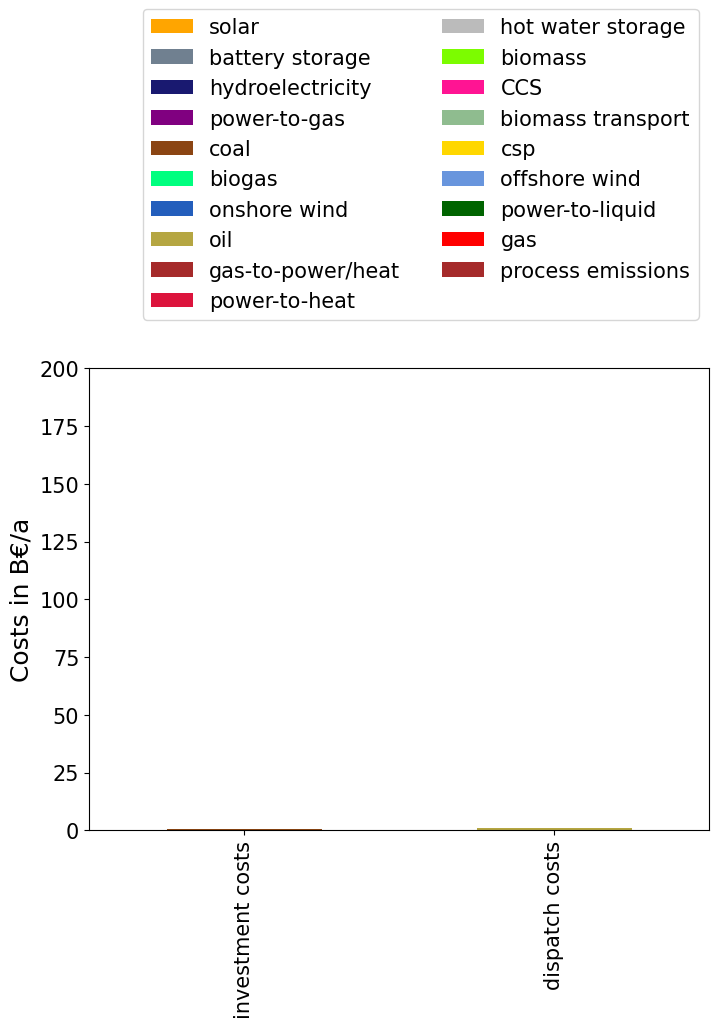

In [92]:
m_cost_ref = calc_mcost(n0,expansion=True)
m_cost_ref.index = m_cost_ref.apply(lambda i: rename_techs_tyndp(i.name), axis=1)
m_cost_ref = m_cost_ref.groupby(m_cost_ref.index).sum()
m_cost_ref['cost_type'] = 'dispatch costs'
m_cost_ref.rename({0:'value'}, axis=1, inplace=True)

cc = pd.DataFrame(data={
    'value':calc_cost(n0,cost_type="capital", expansion=True).sum(),
    'cost_type':['investment costs']*len(calc_cost(n0,cost_type="capital", expansion=True).sum()),
})

ref_costs = pd.concat([cc, m_cost_ref])
ref_costs.value = ref_costs.value.astype(int) / 1e9
ref_costs = ref_costs.loc[ref_costs.value > 0.000001]

ref_costs = ref_costs.pivot(columns='cost_type', values='value')
ref_costs.index = ref_costs.index.map(rename_techs_tyndp)
ref_costs = ref_costs.groupby(ref_costs.index).sum().sort_values(by='investment costs', ascending=False)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(8, 6)

ref_costs = ref_costs.iloc[:, [1,0]]
ref_costs.T.plot.bar(ax=ax, stacked=True, color=tech_colors, alpha=1)

lgd = ax.legend(bbox_to_anchor=(1, 1.8), fontsize=15, ncol=2)
ax.set_ylim(0, 200)
ax.set_ylabel('Costs in B€/a', fontsize=18)
ax.set_xlabel('', fontsize=18)
ax.tick_params(labelsize=15)
fig.savefig('../outputs/system_costs_bar_0exp_2c.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
print(ref_costs)

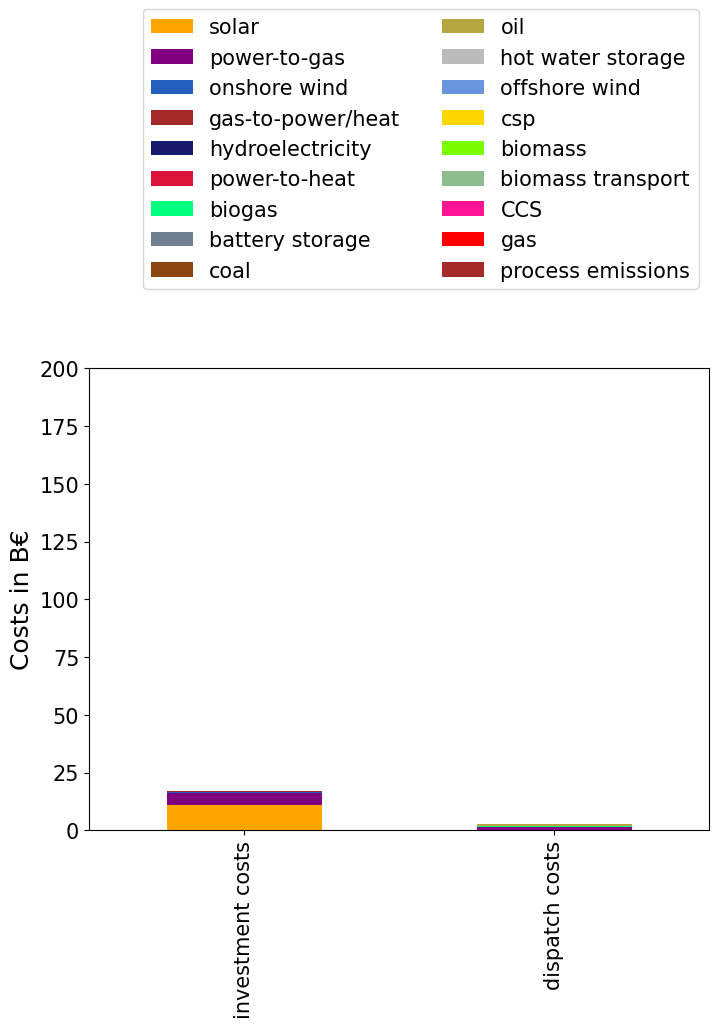

In [93]:
m_cost_ref_1000 = calc_mcost(n1,expansion=True)
m_cost_ref_1000.index = m_cost_ref_1000.apply(lambda i: rename_techs_tyndp(i.name), axis=1)
m_cost_ref_1000 = m_cost_ref_1000.groupby(m_cost_ref_1000.index).sum()
m_cost_ref_1000['cost_type'] = 'dispatch costs'
m_cost_ref_1000.rename({0:'value'}, axis=1, inplace=True)

cc_1000 = pd.DataFrame(data={
    'value':calc_cost(n1,cost_type="capital", expansion=True).sum(),
    'cost_type':['investment costs']*len(calc_cost(n1,cost_type="capital", expansion=True).sum()),
})


ref_costs = pd.concat([cc_1000, m_cost_ref_1000])
ref_costs.value = ref_costs.value.astype(int) / 1e9
ref_costs = ref_costs.loc[ref_costs.value > 0.000001]

ref_costs = ref_costs.pivot(columns='cost_type', values='value').sort_values(by='investment costs', ascending=False)
ref_costs.index = ref_costs.index.map(rename_techs_tyndp)
ref_costs = ref_costs.groupby(ref_costs.index).sum().sort_values(by='investment costs', ascending=False)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(8, 6)

ref_costs = ref_costs.iloc[:, [1,0]]
ref_costs.T.plot.bar(ax=ax, stacked=True, color=tech_colors, alpha=1)

lgd = ax.legend(bbox_to_anchor=(1, 1.8), fontsize=15, ncol=2)
ax.set_ylim(0, 200)
ax.set_ylabel('Costs in B€', fontsize=18)
ax.set_xlabel('', fontsize=18)
ax.tick_params(labelsize=15)
fig.savefig('../outputs/system_costs_bar_538exp_2c.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

# Electricity mix

In [94]:
def calc_generation(n, tech='all'):
    '''''''in TWh'''''''
    gen_t = n.generators_t.p[n.generators.loc[n.generators.bus.str.contains('_AC$')].index].sum()
    gen_agg = pd.DataFrame(data={'bus':gen_t.index,'generation':gen_t.values})
    gen_agg['carrier'] = n.generators.loc[gen_agg.bus, 'carrier'].values
    gen_agg = gen_agg.groupby('carrier').sum() 
    gen_agg["generation"] = gen_agg["generation"]/ 1e6 * n.snapshot_weightings.iloc[0,0]

    # hydro_gen = n.storage_units_t.p.sum().sum() / 1e6 * n.snapshot_weightings.iloc[0,0]
    # gen_agg.loc['hydro'] = [hydro_gen]

    link_gen_pps = n.links.filter(regex=('OCGT|biomass EOP'), axis=0)
    link_gen = -n.links_t.p1[link_gen_pps.index] / 1e6 * n.snapshot_weightings.iloc[0,0]
    link_gen.columns = link_gen_pps.carrier
    link_gen = link_gen.rename({'biomass EOP':'biomass', 'OCGT':'OCGT'}, axis=1)
    link_gen = link_gen.T.groupby(link_gen.T.index).sum().T
    # for c in link_gen.columns:
    #     gen_agg.loc[c] += link_gen[c].sum()

    res_idx = ['solar', 'rooftop-solar', 'onwind', 'onwind2', 'offwind', 'offwind2', 'csp', 'hydro', 'ror']
    if tech == 'all':
        return gen_agg
    elif tech == 'res':
        return gen_agg.loc[res_idx]
    else:
        return gen_agg.loc[tech]
    

def calc_elec_mix(n):
    generation = calc_generation(n) 
    mix = generation.loc[generation.generation > 1]
    return mix.sort_values(by='generation', ascending=False)


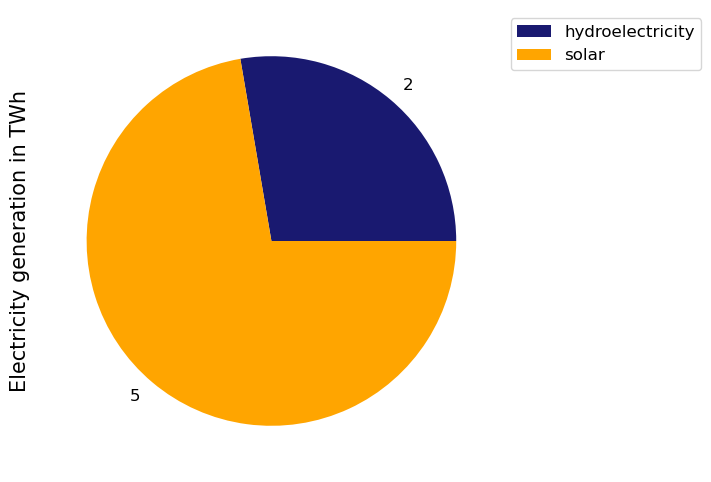

In [95]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(8, 6)

mix = calc_elec_mix(n0)
mix.index.name = 'technology'
mix = mix.reset_index()

mix.technology = mix.technology.apply(lambda t: rename_techs_tyndp(t))
mix = mix.groupby('technology', as_index=False).sum()
colors = mix.technology.apply(lambda t: tech_colors[t])

mix = mix.set_index('technology')

mix.plot.pie(y='generation', ax=ax, colors=colors,labels=mix.generation.round(0).astype(int), legend=True, fontsize=12)

lgd = ax.legend(bbox_to_anchor=(1,1), fontsize=12, labels=mix.index)

ax.set_ylabel('Electricity generation in TWh', fontsize=15)
ax.set_xlabel('', fontsize=15)
ax.tick_params(labelsize=12)
fig.savefig('../outputs/elec_mix_real_noexports.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

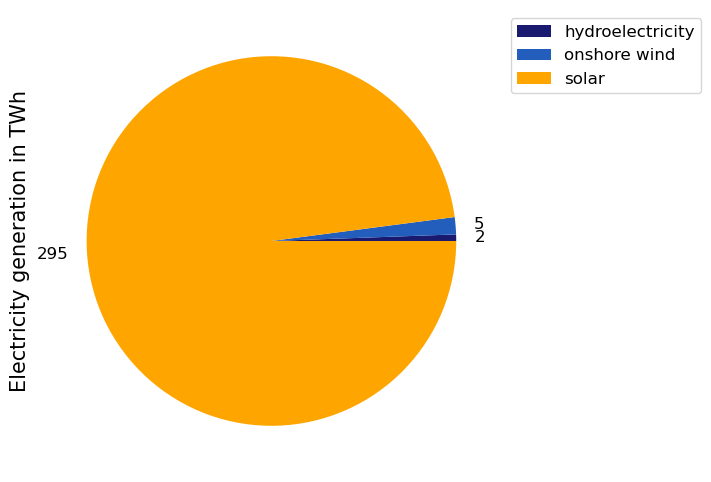

In [96]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(8, 6)

mix = calc_elec_mix(n1)
mix.index.name = 'technology'
mix = mix.reset_index()

mix.technology = mix.technology.apply(lambda t: rename_techs_tyndp(t))
mix = mix.groupby('technology', as_index=False).sum()
colors = mix.technology.apply(lambda t: tech_colors[t])

mix = mix.set_index('technology')

mix.plot.pie(y='generation', ax=ax, colors=colors,labels=mix.generation.round(0).astype(int), legend=True, fontsize=12)

lgd = ax.legend(bbox_to_anchor=(1,1), fontsize=12, labels=mix.index)

ax.set_ylabel('Electricity generation in TWh', fontsize=15)
ax.set_xlabel('', fontsize=15)
ax.tick_params(labelsize=12)
fig.savefig('../outputs/elec_mix_real_538exports.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

# Geo-spatial price distribution

In [106]:
country = gpd.read_file('/nfs/home/raj08555/Git-hypat/pypsa-earth-sec/data_preprocessing/NAM_merged/Namibia_V3.shp')

country['cluster'] = country.ID_NAM2 + '_AC'
country = country.set_index('cluster')
country

,GID_1,GID_0,COUNTRY,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,...,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,Id,ID_1,ID_NAM,ID_NAM2,geometry
cluster,,,,,,,,,,,,,,,,,,,,,
NAM1_AC,NAM.4_1,NAM,Namibia,Kavango,NA,NA,Region,Region,NA,NA.OK,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NAM1,"POLYGON ((22.49848 -17.82185, 22.50306 -18.000..."
NAM2_AC,NAM.7_1,NAM,Namibia,Ohangwena,NA,NA,Region,Region,NA,NA.OW,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NAM2,"POLYGON ((17.99908 -17.39475, 17.99908 -17.520..."
NAM3_AC,NAM.8_1,NAM,Namibia,Omaheke,NA,NA,Region,Region,NA,NA.OH,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NAM3,"POLYGON ((20.99716 -20.33559, 20.99695 -20.957..."
NAM4_AC,NAM.9_1,NAM,Namibia,Omusati,NA,NA,Region,Region,NA,NA.OS,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NAM4,"POLYGON ((15.54680 -17.39119, 15.54761 -17.393..."
NAM5_AC,NAM.10_1,NAM,Namibia,Oshana,NA,NA,Region,Region,NA,NA.ON,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NAM5,"POLYGON ((15.99928 -17.68952, 15.99928 -17.722..."
NAM6_AC,NAM.11_1,NAM,Namibia,Oshikoto,NA,NA,Region,Region,NA,NA.OT,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NAM6,"POLYGON ((17.99907 -17.75081, 17.99907 -17.918..."
NAM7_AC,NAM.12_1,NAM,Namibia,Otjozondjupa,NA,NA,Region,Region,NA,NA.OD,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NAM7,"POLYGON ((20.99755 -19.18318, 20.99727 -19.999..."
NAM8_AC,NAM.13_1,NAM,Namibia,Zambezi,Caprivi,NA,Region,Region,NA,NA.CA,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NAM8,"POLYGON ((22.50413 -18.11382, 22.50408 -18.112..."
NAM9_AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NAM9,"POLYGON ((18.11614 -21.70869, 18.13567 -21.754..."


In [98]:
country['wap_elec'] = calc_wap_elec(n0, agg=False)
country['wap_elec_exp'] = calc_wap_elec(n1, agg=False)
country['wap_elec_dev'] = country['wap_elec_exp'] - country['wap_elec']


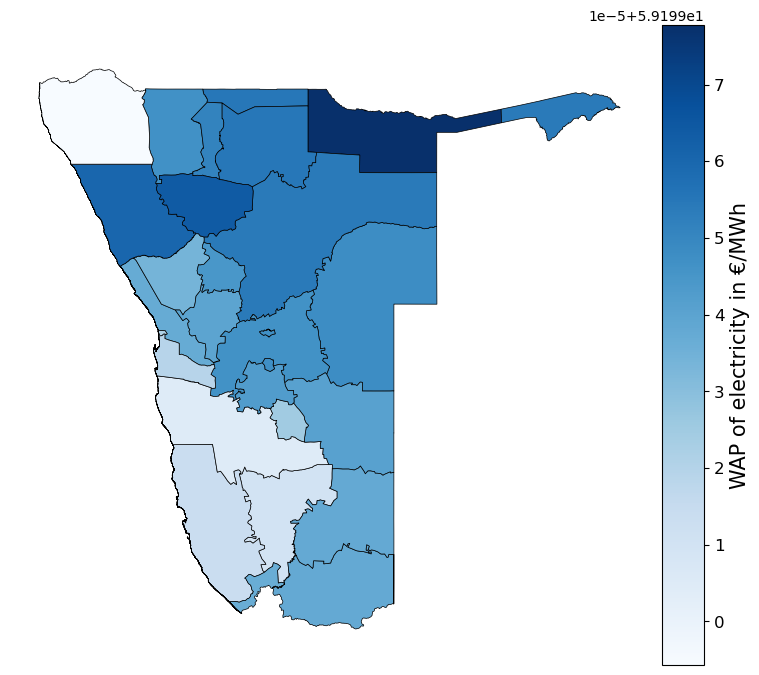

In [99]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(14, 8)

country.plot(
    ax=ax,
    column='wap_elec',
    edgecolor="black",
    linewidth=0.5,
    legend_kwds={'label':'Energy demand in TWh'},
    cmap='Blues',
)

cax = fig.add_axes([0.75, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=country.wap_elec.min(), vmax=country.wap_elec.max()))
sm._A = []
cbr = fig.colorbar(sm, cax=cax)
cbr.ax.tick_params(labelsize=12) 
cbr.set_label('WAP of electricity in €/MWh', fontsize=15)

ax.set_axis_off()
fig.savefig('../outputs/wap_elec_2030_real_noexp.pdf')

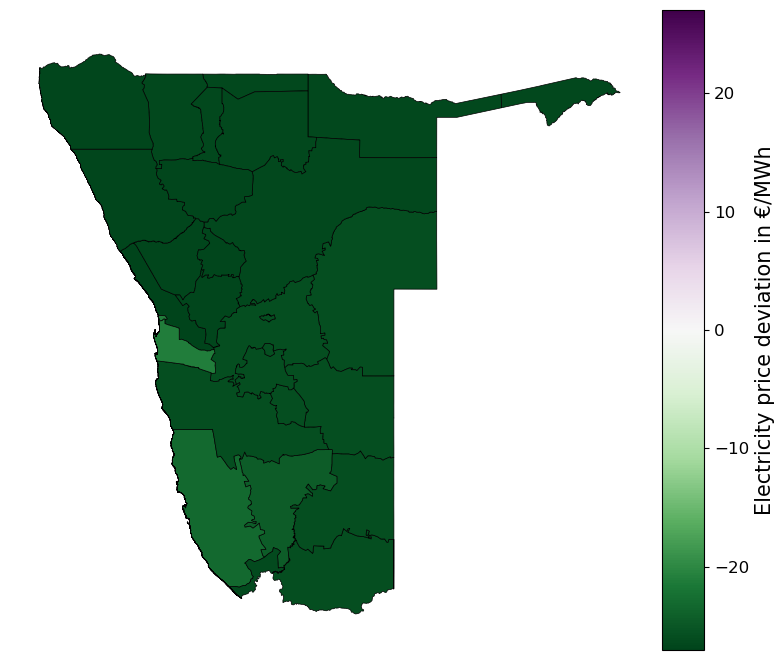

In [100]:

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(14, 8)

# normalize color
vmin, vmax, vcenter = country.wap_elec_dev.min(), country.wap_elec_dev.max(), 0
v_abs = max(abs(vmin), abs(vmax))
norm = TwoSlopeNorm(vmin=-v_abs, vcenter=vcenter, vmax=v_abs)
# create a normalized colorbar
cmap = 'PRGn_r'
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

country.plot(
    ax=ax,
    column='wap_elec_dev',
    edgecolor="black",
    linewidth=0.5,
    legend_kwds={'label':'Energy demand in TWh'},
    #color=region_dict[int(region)][0],
    cmap=cmap,
    norm=norm
    #legend=True
)

cax = fig.add_axes([0.75, 0.1, 0.03, 0.8])
#states.apply(lambda s: ax.annotate(text=s['sigla'], xy=s.geometry.centroid.coords[0], ha='center', va='center'), axis=1)

cbr = fig.colorbar(cbar, cax=cax)
#ax.legend(frameon=True, loc=3)
cbr.ax.tick_params(labelsize=12) 
cbr.set_label('Electricity price deviation in €/MWh', fontsize=15)

ax.set_axis_off()
fig.savefig('../outputs/wap_elec_2050_real_538exp.pdf')

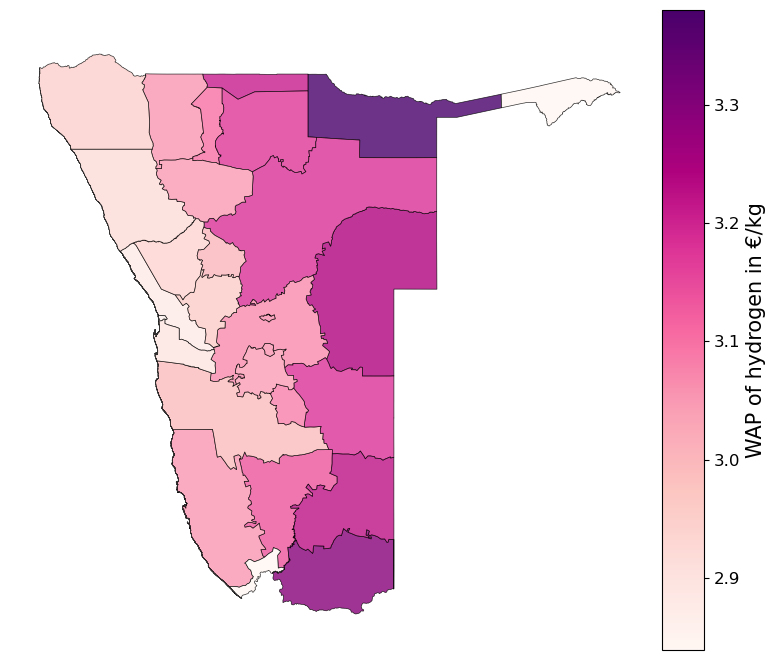

In [101]:
wap_h2 = calc_wap_h2(n0, agg=False)
wap_h2.index = wap_h2.index.str[:-3]
country['wap_h2'] = wap_h2

wap_h2_exp= calc_wap_h2(n1, agg=False)
wap_h2_exp.index = wap_h2_exp.index.str[:-3]
country['wap_h2_exp'] = wap_h2_exp

country['wap_h2_dev'] = country['wap_h2_exp'] - country['wap_h2']


fig, ax = plt.subplots(1, 1)
fig.set_size_inches(14, 8)

country.plot(
    ax=ax,
    column='wap_h2',
    edgecolor="black",
    linewidth=0.5,
    legend_kwds={'label':'Energy demand in TWh'},
    #color=region_dict[int(region)][0],
    cmap='RdPu',
    #legend=True,
    alpha=0.8
)

cax = fig.add_axes([0.75, 0.1, 0.03, 0.8])
#states.apply(lambda s: ax.annotate(text=s['sigla'], xy=s.geometry.centroid.coords[0], ha='center', va='center'), axis=1)
sm = plt.cm.ScalarMappable(cmap='RdPu', norm=plt.Normalize(vmin=country.wap_h2.min(), vmax=country.wap_h2.max()))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
cbr = fig.colorbar(sm, cax=cax)
#ax.legend(frameon=True, loc=3)
cbr.ax.tick_params(labelsize=12) 
cbr.set_label('WAP of hydrogen in €/kg', fontsize=15)

ax.set_axis_off()
fig.savefig('../outputs/wap_h2_2050_real_noexp.pdf')


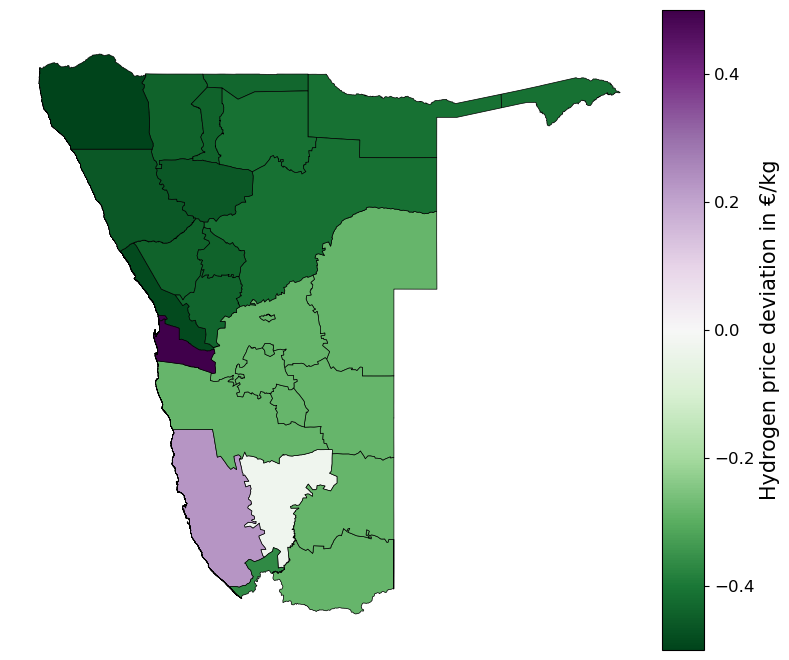

In [102]:

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(14, 8)

# normalize color
vmin, vmax, vcenter = country.wap_h2_dev.min(), country.wap_h2_dev.max(), 0
v_abs = max(abs(vmin), abs(vmax))
norm = TwoSlopeNorm(vmin=-v_abs, vcenter=vcenter, vmax=v_abs)
# create a normalized colorbar
cmap = 'PRGn_r'
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

country.plot(
    ax=ax,
    column='wap_h2_dev',
    edgecolor="black",
    linewidth=0.5,
    legend_kwds={'label':'Energy demand in TWh'},
    #color=region_dict[int(region)][0],
    cmap=cmap,
    #legend=True
)

cax = fig.add_axes([0.75, 0.1, 0.03, 0.8])
cbr = fig.colorbar(cbar, cax=cax)
cbr.ax.tick_params(labelsize=12) 
cbr.set_label('Hydrogen price deviation in €/kg', fontsize=15)

ax.set_axis_off()

# Expansion of different components for different export quantities

In [145]:
def plot_elec_capas(networks, drop_exp_ports=True):

    df = pd.DataFrame()

    for q in [0,1,10,50,200,538]:
        n = networks[q]
        elecs = n.links.filter(like='Electrolysis', axis=0).set_index('bus0')['p_nom_opt'] / 1e3
        elecs = elecs.rename('{} TWh of hydrogen exports'.format(q))
        df = pd.concat([df, elecs], axis=1)

    df.index = country.loc[df.index, 'ID_NAM2']
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(20, 8)
    #ax2 = ax.twinx()
    export_ports = ['NAM19','NAM12']
    if drop_exp_ports:
        df.drop(export_ports, inplace=True)
        drop = 'drop_exp'
    else:
        df.drop(df.drop(export_ports).index, inplace=True)
        drop = '_exp'
    df.plot.bar(ax=ax, legend=True, width=0.8, cmap='spring_r')
    ax.set_xlabel('FU', fontsize=15)
    ax.set_ylabel('Electrolyzer capacity in GW', fontsize=15)
    #df.Electrolyzer.plot.bar(ax=ax2, color=tech_colors['power-to-gas'], width = 0.2, position=0, legend=True)
    fig.savefig('../outputs/elec_opt_geo_dist_realistic_2030{}.pdf'.format(drop), transparent=True, bbox_inches="tight")


def plot_pipeline_capas(networks):

    df = pd.DataFrame()

    for q in [0, 538]:
        n = networks[q]
        pipelines = n.links.filter(like='H2 pipeline', axis=0)[['p_nom_opt', 'bus0', 'bus1', 'length']]
        pipelines['{}'.format(q)] = pipelines.p_nom_opt * pipelines.length
        #pipelines = pipelines.rename('{}'.format(q))
        pipelines = pipelines.groupby(['bus0', 'bus1'], as_index=True).sum()['{}'.format(q)]
        df = pd.concat([df, pipelines], axis=1)
        
    #df.reset_index(inplace=True)
    df['bus0'] = country.loc[df.index.get_level_values(0).str.strip(' H2'), 'ID_NAM2'].values
    df['bus1'] = country.loc[df.index.get_level_values(1).str.strip(' H2'), 'ID_NAM2'].values
    #ne = ['Piauí', 'Rio Grande do Norte', 'Paraíba', 'Pernambuco', 'Alagoas', 'Sergipe', 'Ceará', 'Bahia']
    df.reset_index(inplace=True)
    #df = df.loc[df.bus0.isin(ne)& df.bus1.isin(ne)]
    df.index = df.bus0 + ' - ' + df.bus1
    df = df.groupby(df.index).sum()

    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(8,6)
    #ax2 = ax.twinx()
    #export_ports = ['Ceará', 'Bahia', 'Rio de Janeiro', 'Rio Grande do Sul']
    df = df[['0', '538']]
    df = df.sort_values(by='0', ascending=False) / 1e3
    df.T.plot.bar(ax=ax, legend=True, stacked=False)

    ax.legend(bbox_to_anchor=(0.48, 1.), fontsize=12)
    print(df)

    ax.set_ylabel('Pipeline capacity in GWkm', fontsize=15)
    ax.set_xlabel('Hydrogen export quantity in TWh', fontsize=15)
    ax.set_ylim(0, 3500)
    ax.tick_params(labelsize=12)
    #df.Electrolyzer.plot.bar(ax=ax2, color=tech_colors['power-to-gas'], width = 0.2, position=0, legend=True)
    fig.savefig('../outputs/pipeline_opt_ne_realistic_2030.pdf', transparent=True, bbox_inches="tight")


def plot_solar_capas(networks, drop_exp_ports=True):

    df = pd.DataFrame()

    for q in [0,1,10,50,200,538]:
        n = networks[q]
        solar_pp = n.generators.loc[n.generators.carrier == 'solar'].set_index('bus').p_nom_opt / 1e3
        solar_pp = solar_pp.rename('{}'.format(q))
        df = pd.concat([df, solar_pp], axis=1)

    df.index = country.loc[df.index, 'ID_NAM2']
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(20, 8)
    #ax2 = ax.twinx()
    export_ports = ['NAM19','NAM12']
    if drop_exp_ports:
        df.drop(export_ports, inplace=True)
        drop = 'drop_exp'
    else:
        df.drop(df.drop(export_ports).index, inplace=True)
        drop = '_exp'
    #df = df.loc[['Mato Grosso do Sul', 'Pará', 'Paraíba', 'Piauí', 'Rio Grande do Norte', 'Sergipe', 'Tocantins', 'Alagoas', 'Goiás']]
    #df.drop(export_ports, inplace=True)
    df.plot.bar(ax=ax, legend=True, width=0.8, cmap='Wistia')
    #df.Electrolyzer.plot.bar(ax=ax2, color=tech_colors['power-to-gas'], width = 0.2, position=0, legend=True)
    ax.set_xlabel('FU', fontsize=15)
    ax.set_ylabel('Solar PV capacity in GW', fontsize=15)
    fig.savefig('../outputs/solar_opt_geo_dist_realistic_2030{}.pdf'.format(drop), transparent=True, bbox_inches="tight")


def plot_solar_wind_capas(networks, drop_exp_ports=True):

    df = pd.DataFrame()

    for q in [0,1,10,50,200,538]:
        n = networks[q]
        solar_pp = n.generators.loc[(n.generators.carrier == 'solar') | (n.generators.carrier.str.contains('onwind'))][['bus', 'carrier', 'p_nom_opt']]
        solar_pp.carrier = solar_pp.carrier.str.strip('2')
        solar_pp = solar_pp.groupby(['bus', 'carrier']).sum()
        solar_pp = solar_pp.rename({'p_nom_opt':'{}'.format(q)}, axis=1)
        df = pd.concat([df, solar_pp], axis=1)

    df.reset_index(level=[1],inplace=True)
    df['fu'] = country.loc[df.index, 'ID_NAM2']
    df = df.reset_index().drop('bus', axis=1).groupby(['fu', 'carrier']).sum().divide(1e3)
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(20, 8)
    #ax2 = ax.twinx()
    export_ports = ['NAM19','NAM12']
    if drop_exp_ports:
        df.drop(export_ports, inplace=True)
        drop = 'drop_exp'
    else:
        df.drop(df.drop(export_ports).index, inplace=True)
        drop = '_exp'
    #df.drop(export_ports, inplace=True)
    
    # Define the number of bars and the width for each cluster
    num_bars = len(df.index.get_level_values(0).unique())
    bar_width = 0.1

    # Set the position of each bar on the x-axis
    x = np.arange(num_bars)

    cm_solar = plt.cm.Wistia
    cm_wind = plt.cm.winter_r

    for i, col in enumerate(df.columns):
        
        ax.bar(x + i * bar_width,df.xs('solar', level=1)[col], bar_width,  color=cm_solar(i/len(df.columns)), label='{} TWh of exports (solar)'.format(col))
        ax.bar(x + i * bar_width,df.xs('onwind', level=1)[col], bar_width,  color=cm_wind(i/len(df.columns)), bottom=df.xs('solar', level=1)[col], label='{} TWh of exports (wind)'.format(col))
    # Set the x-axis labels and ticks
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [0,2,4,6,8,10,12,1,3,5,7,9,11,13]
    #plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], ncol=2, fontsize="15", bbox_to_anchor=[0.75, 1.4])
    ax.set_xticks(x + (len(df.columns[1:]) / 2) * bar_width)
    ax.set_xticklabels(df.index.get_level_values(0).unique(), fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_xlabel('FU', fontsize=18)
    ax.set_ylabel('Solar and wind capacities in GW', fontsize=20)
    fig.savefig('../outputs/solar_wind_opt_exports_realistic_2030{}.pdf'.format(drop), transparent=True, bbox_inches="tight")


def plot_batt_capas(networks, drop_exp_ports=True):

    df = pd.DataFrame()

    for q in [0,1,10,50,200,538]:
        n = networks[q]
        battery = n.stores.filter(regex='battery$', axis=0).set_index('bus').e_nom_opt / 1e3
        battery.index = battery.index.str[:8].str.strip()
        battery = battery.groupby(battery.index).sum()
        battery = battery.rename('{}'.format(q))
        df = pd.concat([df, battery], axis=1)

    min_val, max_val = 0.3,0.9
    n = 10
    orig_cmap = plt.cm.bone_r
    colors = orig_cmap(np.linspace(min_val, max_val, n))
    cmap = mpl.colors.LinearSegmentedColormap.from_list("mycmap", colors)

    df.index = country.loc[df.index, 'ID_NAM2']
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(20, 8)
    #ax2 = ax.twinx()
    export_ports = ['NAM19','NAM12']
    if drop_exp_ports:
        df.drop(export_ports, inplace=True)
        drop = 'drop_exp'
    else:
        df.drop(df.drop(export_ports).index, inplace=True)
        drop = '_exp'
    #df.drop(export_ports, inplace=True)
    df.plot.bar(ax=ax, legend=True, width=0.8, cmap=cmap)
    ax.set_xlabel('FU', fontsize=15)
    ax.set_ylabel('Battery in GWh', fontsize=15)
    #df.Electrolyzer.plot.bar(ax=ax2, color=tech_colors['power-to-gas'], width = 0.2, position=0, legend=True)
    fig.savefig('../outputs/battery_opt_geo_dist_realistic_2030{}.pdf'.format(drop), transparent=True, bbox_inches="tight")


### Electrolyzers

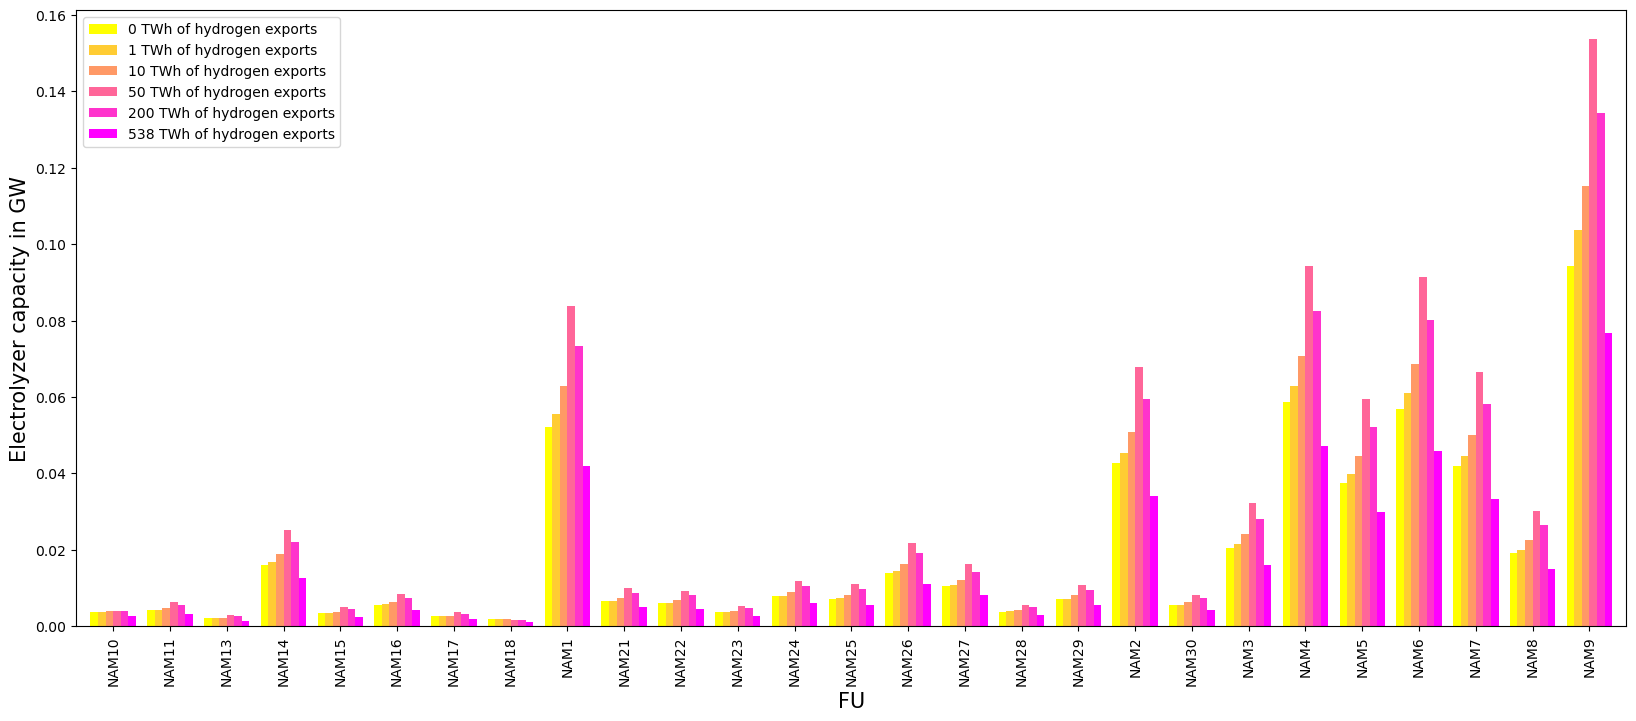

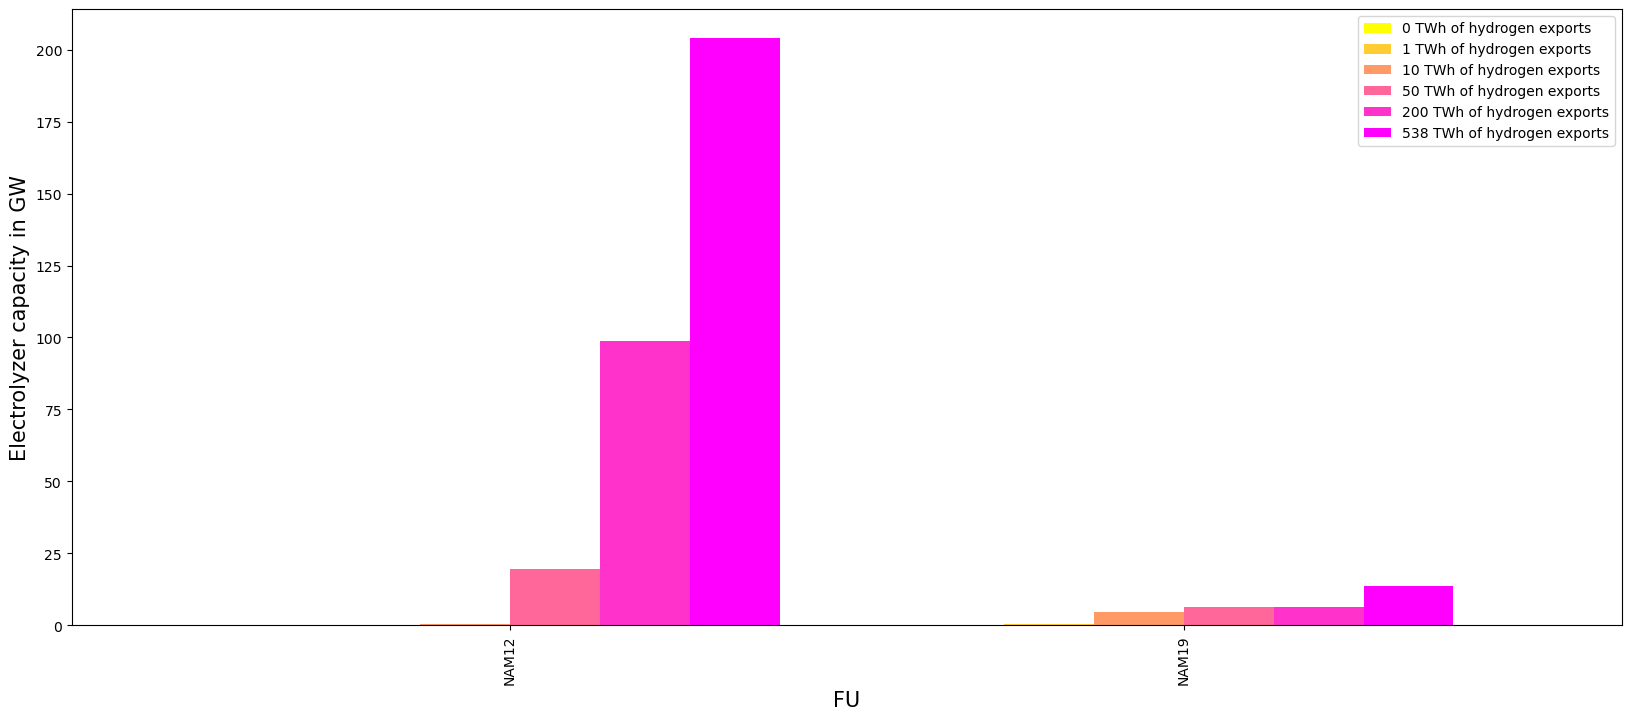

In [114]:

plot_elec_capas(networks[2030]['BS'], drop_exp_ports=True)
plot_elec_capas(networks[2030]['BS'], drop_exp_ports=False)

### Pipelines

In [ ]:


plot_pipeline_capas(networks[2030]['AP'])


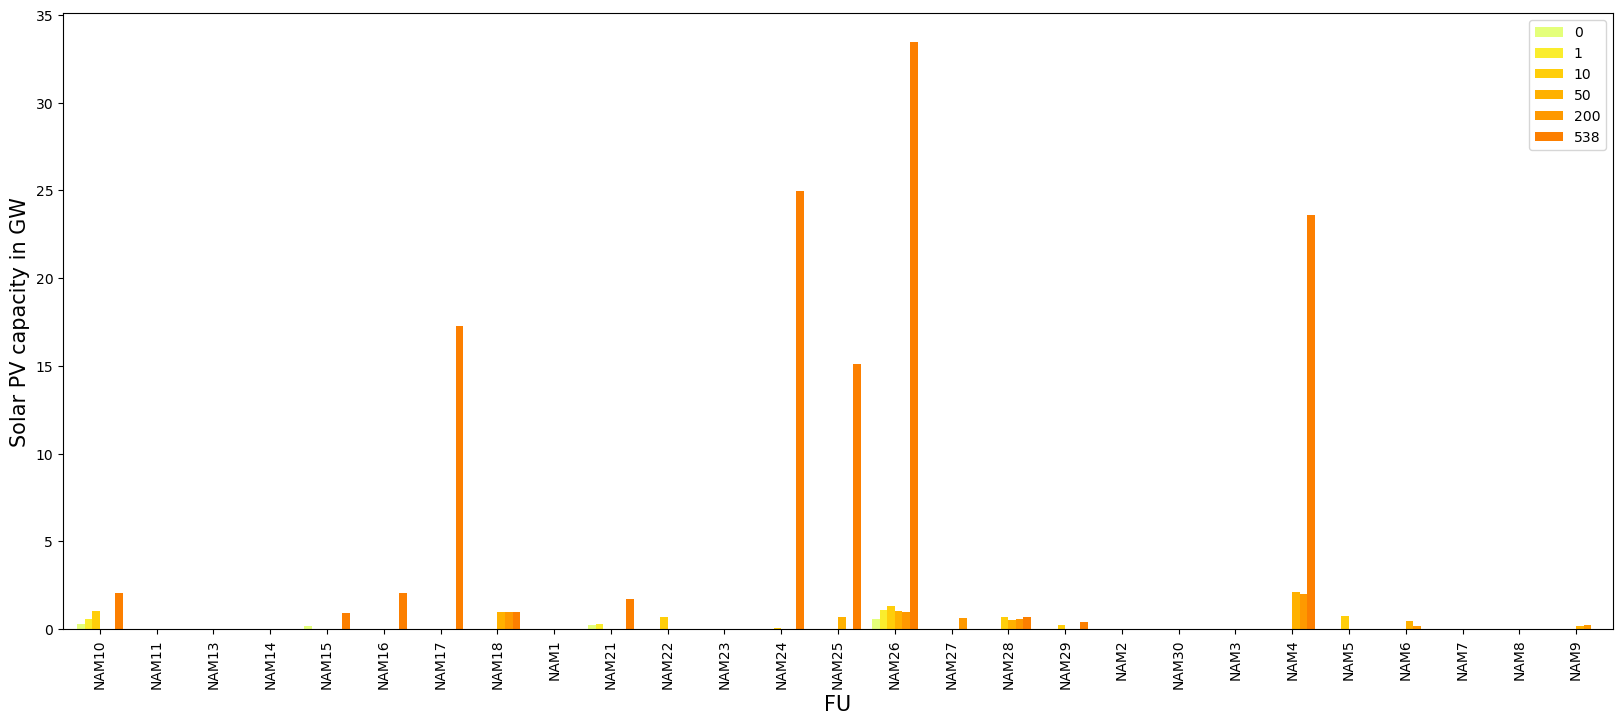

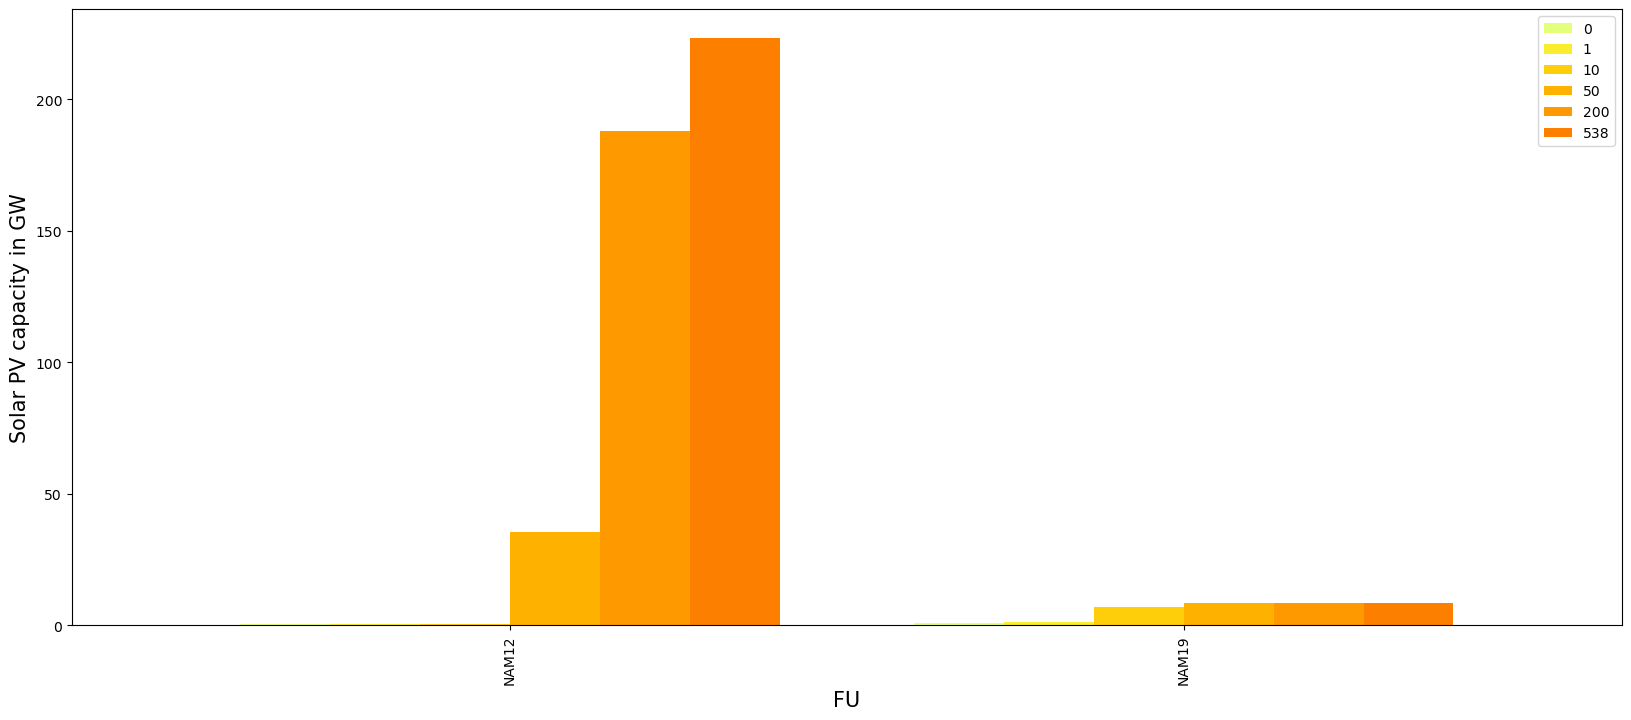

In [123]:

plot_solar_capas(networks[2030]['AP'], drop_exp_ports=True)
plot_solar_capas(networks[2030]['AP'], drop_exp_ports=False)

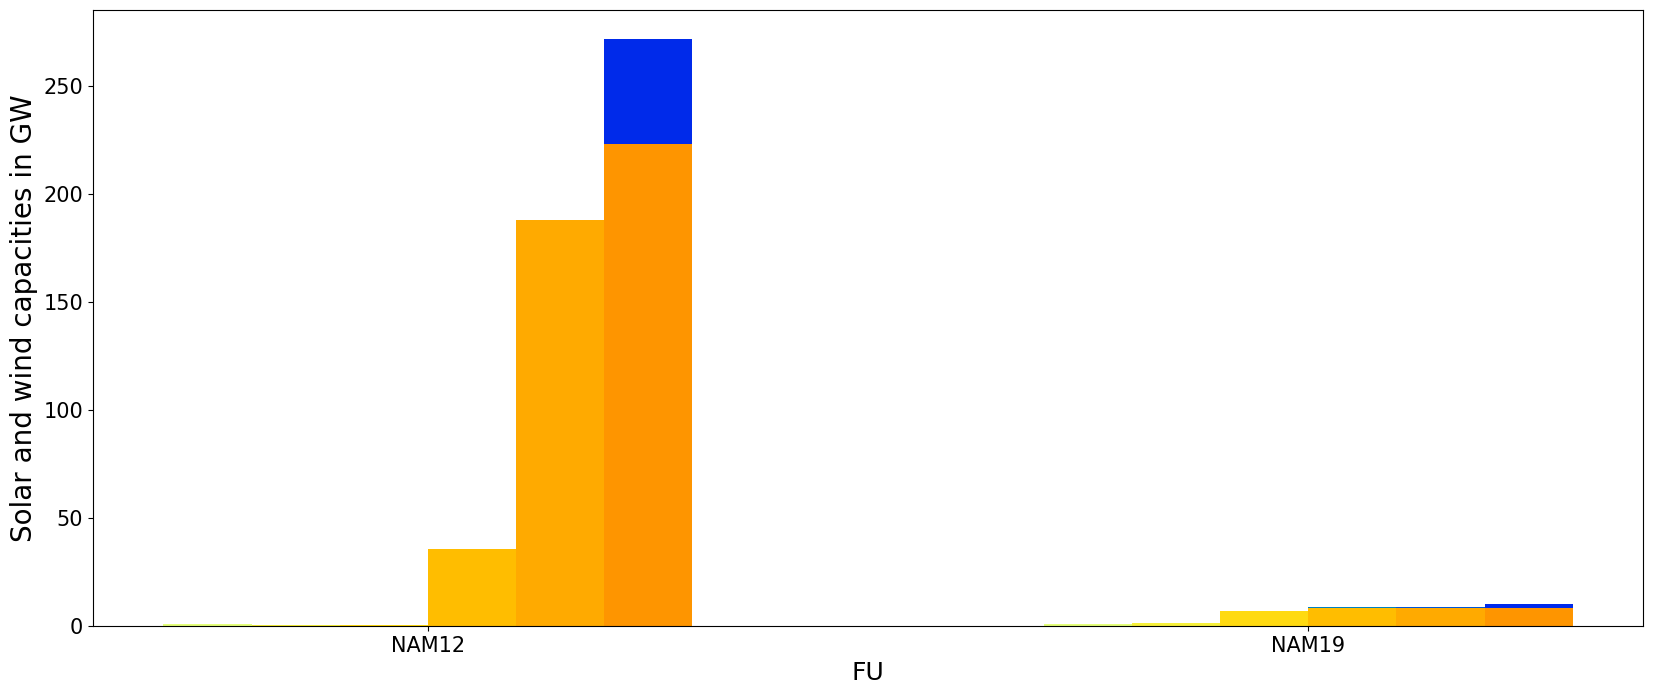

In [138]:
plot_solar_wind_capas(networks[2030]['AP'], drop_exp_ports=False)

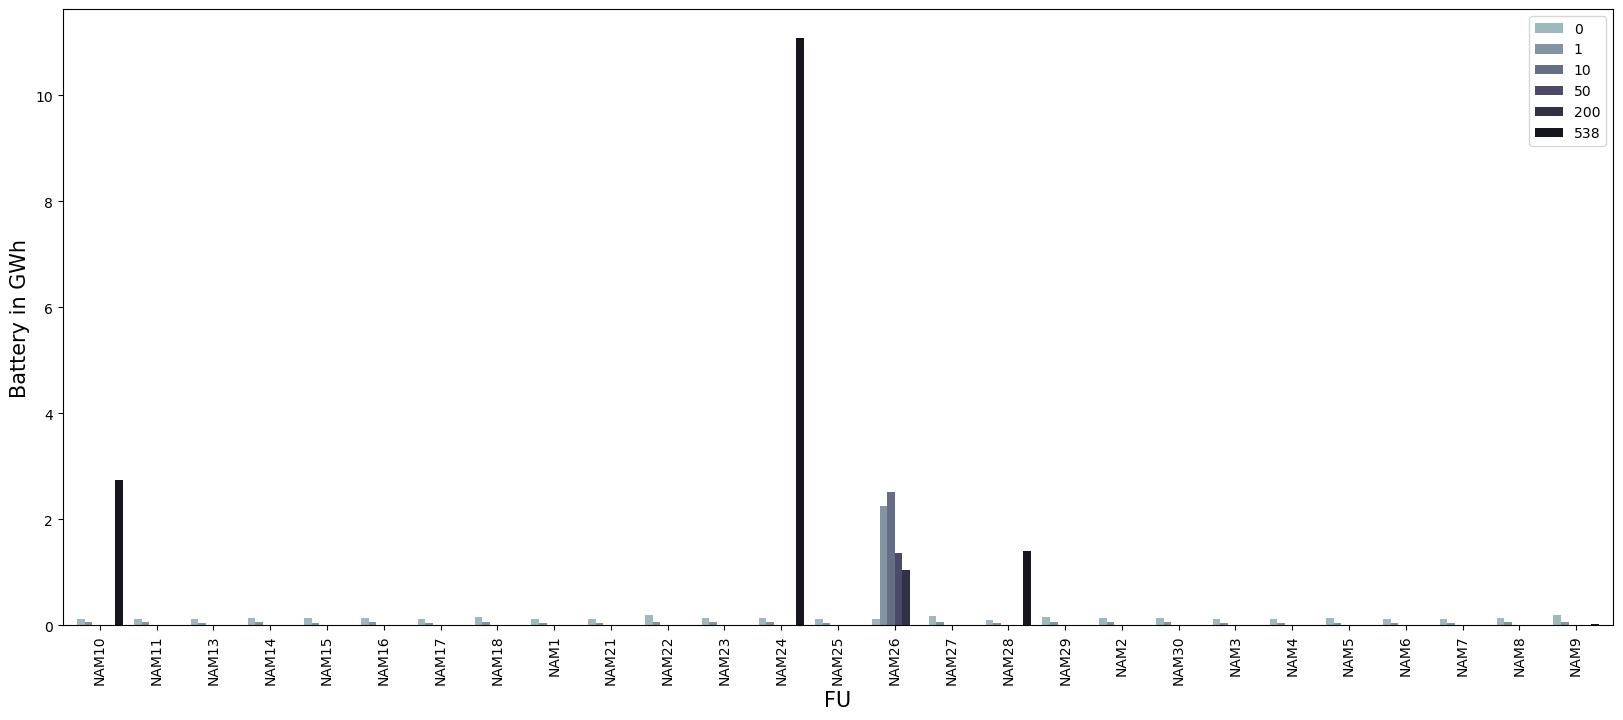

In [146]:
plot_batt_capas(networks[2030]['AP'])


# Energy balance

In [131]:
def rename_techs_demand(label):
    prefix_to_remove = [
        #"residential ",
        #"services ",
        "urban ",
        "rural ",
        "central ",
        "decentral ",
    ]

    rename_if_contains_dict = {
        "water tanks": "hot water storage",
        "retrofitting": "building retrofitting",
        "battery": "battery storage",
        "Li ion":"battery storage",
        "BEV charge":"battery storage",
        "V2G":"battery storage",
        "CCS": "CCS",
        #"":"gas"
        #"CC": "CCS",
        "co2": "CCS",
        "CO2": "CCS",
        'heat':'heat',
        'electricity':'electricity'
        
    }

    rename = {
        'H2 for industry': 'H2 industry', 'H2 for shipping':'H2 transport', 'agriculture oil':'oil agriculture',
       'kerosene for aviation':'oil transport', 'solid biomass for industry':'biomass industry',
       'land transport EV':'electricity transport', 'land transport fuel cell':'H2 transport', 'land transport oil':'oil transport',
       'naphtha for industry':'oil industry',  'rail transport oil':'oil transport',
       'residential biomass':'biomass residential', 'residential oil':'oil residential', 'services biomass':'biomass services',
       'shipping oil':'oil transport', 'AC':'electricity', 'gas for industry':'gas industry', 'H2':'H2 export'
    }
    rename = {
        'H2':'H2 export', 'H2 for industry': 'H2', 'H2 for shipping':'H2', 'agriculture oil':'oil',
       'kerosene for aviation':'oil', 'solid biomass for industry':'biomass',
       'land transport EV':'electricity', 'land transport fuel cell':'H2', 'land transport oil':'oil',
       'naphtha for industry':'oil',  'rail transport oil':'oil',
       'residential biomass':'biomass', 'residential oil':'oil', 'services biomass':'biomass',
       'shipping oil':'oil', 'AC':'electricity', 'gas for industry':'gas'
    }

    for ptr in prefix_to_remove:
        if label[: len(ptr)] == ptr:
            label = label[len(ptr) :]


    for old, new in rename_if_contains_dict.items():
        if old in label:
            label = new

    for old, new in rename.items():
        if old == label:
            label = new
    return label
def rename_techs(label):
    prefix_to_remove = [
        "residential ",
        "services ",
        "urban ",
        "rural ",
        "central ",
        "decentral ",
    ]

    rename_if_contains = [
        "CHP",
        "gas boiler",
        "biogas",
        "solar thermal",
        "air heat pump",
        "ground heat pump",
        "resistive heater",
        "Fischer-Tropsch",
    ]

    rename_if_contains_dict = {
        "water tanks": "hot water storage",
        "retrofitting": "building retrofitting",
        #"H2": "hydrogen storage",
        "BEV":"BEV",
        "battery": "battery storage",
        "Li ion":"battery storage",
        "BEV charge":"EV battery",
        #"V2G":"battery storage",
        "CCS": "CCS",
        #"":"gas"
        #"CC": "CCS",
        "co2": "CCS",
        "CO2": "CCS",
        
    }

    rename = {
        "solar": "solar PV",
        "Sabatier": "methanation",
        "offwind": "offshore wind",
        "offwind2": "offshore wind",
        "offwind-ac": "offshore wind (AC)",
        "offwind-dc": "offshore wind (DC)",
        "onwind": "onshore wind",
        "onwind2": "onshore wind",
        "ror": "hydroelectricity",
        "hydro": "hydroelectricity",
        "PHS": "hydroelectricity",
        "co2 Store": "DAC",
        "co2 stored": "CO2 sequestration",
        "AC": "transmission lines",
        "DC": "transmission lines",
        "B2B": "transmission lines",
        'solid biomass':'biomass',
        'biomass EOP':'biomass',
        'DAC':'CCS',
        'solid biomass for industry CC':'biomass CC',
        'gas for industry CC':'gas CC',
        'solid biomass transport':'biomass transport',
        'gas for industry':'gas',
        'solid biomass for industry':'biomass',
        'process emissions CC':'process emissions CC',
        'H2':'H2 storage'
    }

    for ptr in prefix_to_remove:
        if label[: len(ptr)] == ptr:
            label = label[len(ptr) :]

    for rif in rename_if_contains:
        if rif in label:
            label = rif

    for old, new in rename_if_contains_dict.items():
        if old in label:
            label = new

    for old, new in rename.items():
        if old == label:
            label = new
    return label
def rename_techs_tyndp(tech):
    tech = rename_techs(tech)
    if "heat pump" in tech or "resistive heater" in tech:
        return "power-to-heat"
    # elif tech in ["methanation", "hydrogen storage", "helmeth", "H2 Electrolysis"]:
    #     return "power-to-gas"
    # elif tech in ["OCGT", "CHP", "gas boiler", 'CCGT']:
    #     return "gas-to-power/heat"
    # elif "solar" in tech:
    #     return "solar"
    elif tech == "Fischer-Tropsch":
        return "power-to-liquid"
    elif "offshore wind" in tech:
        return "offshore wind"
    else:
        return tech

def assign_location(n):
    for c in n.iterate_components(n.one_port_components | n.branch_components):
        ifind = pd.Series(c.df.index.str.find(" ", start=4), c.df.index)

        for i in ifind.value_counts().index:
            # these have already been assigned defaults
            if i == -1:
                continue

            names = ifind.index[ifind == i]

            c.df.loc[names, "location"] = names.str[:i]

color_dict = {
    'H2 industry':'deeppink', 'H2 export':'violet', 'H2 transport':'deeppink', 'oil agriculture':'darkkhaki',
    'oil transport':'olive', 'biomass industry':'forestgreen', 'battery storage':'grey', 'biogas':'springgreen',
    'electricity transport':'deepskyblue', 'process emissions':'chocolate', 'biomass':'lawngreen', 'gas':'red', 'power-to-gas':'purple',
    'oil industry':'darkolivegreen', 'gas industry':'red', 'heat':'darkred', 'oil':'olive', 'hot water storage':'orange',
    'biomass residential':'lawngreen', 'oil residential':'darkgoldenrod', 'biomass services':'limegreen', 'electricity':'steelblue', 'conversion losses':'black'
}

ValueError: When stacked is True, each column must be either all positive or all negative. Column 'conversion losses' contains both positive and negative values

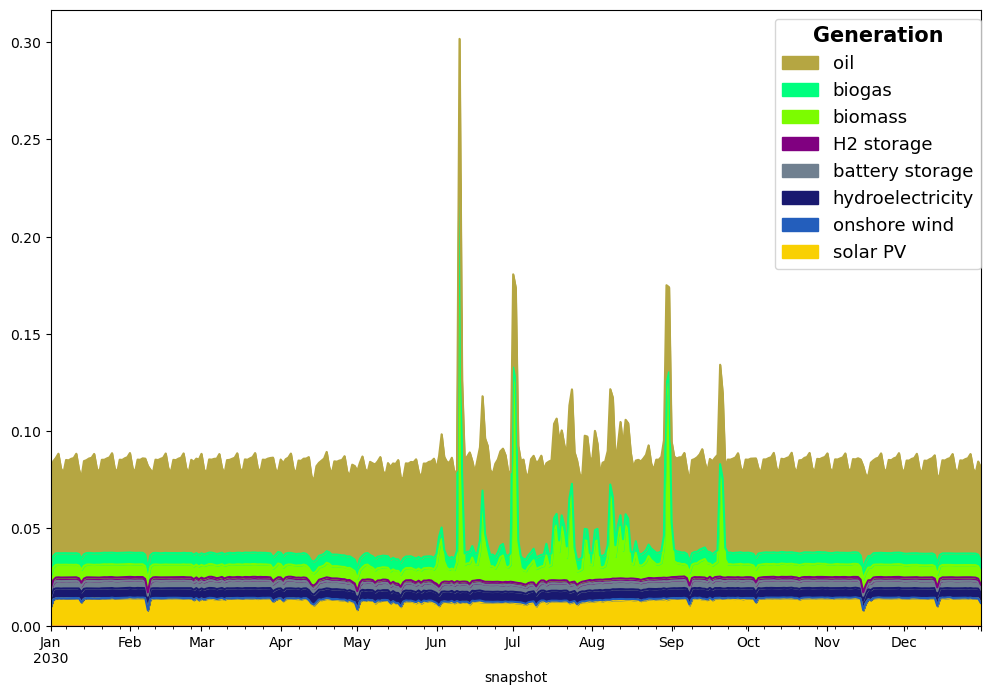

In [136]:
n = n0
loads_dom = n.loads_t.p.filter(regex='_AC') / 1e6 *3
loads_dom.columns = n.loads.loc[loads_dom.columns, 'carrier'].str.strip().apply(rename_techs_demand)
loads_dom = loads_dom.T.groupby(loads_dom.columns).sum().T
loads = loads_dom
gens = n.generators_t.p / 1e6 * 3
gens.columns = n.generators.loc[gens.columns, 'carrier'].str.strip().apply(rename_techs_tyndp)
gens = gens.T.groupby(gens.columns).sum().T


gens_hydro = n.storage_units_t.p_dispatch / 1e6 * 3
gens_hydro.columns = n.storage_units.loc[gens_hydro.columns, 'carrier'].str.strip().apply(rename_techs_tyndp)
gens_hydro = gens_hydro.T.groupby(gens_hydro.columns).sum().T

gen_stor = n.stores_t.p.filter(regex='biomass|oil|biogas|H2 Store|battery|gas Store') / 1e6 * 3
gen_stor.columns = n.stores.loc[gen_stor.columns,'carrier'].str.strip().apply(rename_techs_tyndp)


gen_stor = gen_stor.T.groupby(gen_stor.columns).sum().T


gens = pd.concat([gens, gens_hydro, gen_stor.clip(lower=0)]).fillna(0)
gens = gens.T.groupby(gens.T.index).sum().T
gens = gens.groupby(gens.index).sum()

loads = pd.concat([loads,  -gen_stor.clip(upper=0)]).fillna(0)
loads = loads.groupby(loads.index).sum()

loads = -loads.resample('D').sum().round(decimals=6)#.clip(lower=0.01)
gens = gens.resample('D').sum().round(decimals=6)#.clip(lower=0.01)


fig = plt.figure()
fig.set_size_inches(12, 8)
ax1 = fig.add_subplot(111)

loads=loads.sort_index(axis=1)
gens=gens.sort_index(axis=1)

loads = loads.loc[:, loads.sum() < -0.001]
gens = gens.loc[:, gens.sum() > 0.001]

loads.index = loads.index.map(lambda t: t.replace(year=2030))
gens.index = gens.index.map(lambda t: t.replace(year=2030))

gen_cols = ['solar PV', 'onshore wind', 'hydroelectricity', 'battery storage', 'H2 storage', 'biomass', 'biogas', 'oil']
gens = gens[gen_cols]
gens.plot.area(color=tech_colors, ax=ax1, stacked=True, alpha=1)
handles_gen, labels_gen = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(reversed(handles_gen), reversed(labels_gen), bbox_to_anchor=(1.01, 1.0), title='Generation', title_fontproperties={'weight':'bold', 'size':'15'}, fontsize=13)

conv_losses = -(gens.sum(axis=1) + loads.sum(axis=1))
loads['conversion losses'] = conv_losses
loads.plot.area(color=tech_colors, ax=ax1, stacked=True, alpha=1)
handles_loads, labels_loads = ax1.get_legend_handles_labels()
lgd2 = ax1.legend(handles_loads[len(handles_gen):], labels_loads[len(labels_gen):], bbox_to_anchor=(1.01, 0.48), title='Load', title_fontproperties={'weight':'bold', 'size':'15'}, fontsize=13)
plt.gca().add_artist(lgd1)

ax1.set_ylabel('Daily energy balance in TWh', fontsize=18)
ax1.set_xlabel('Timestep', fontsize=18)
ax1.set_ylim([loads.sum(axis=1).min(), gens.sum(axis=1).max()])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.tight_layout()
fig.savefig('../outputs/energy_balance_real_0exp.pdf')

/nfs/home/raj08555/.conda/envs/pypsa-hypat/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1598: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


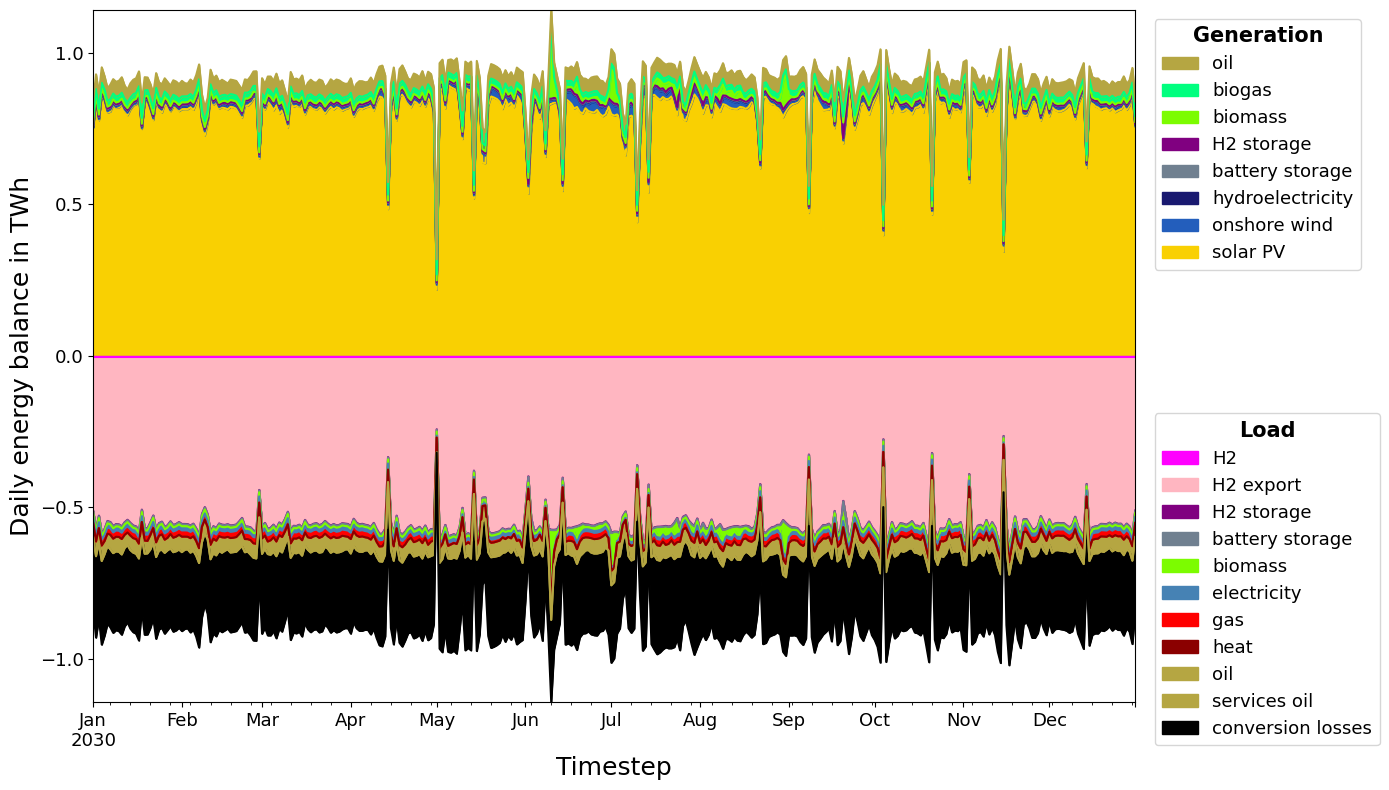

In [137]:
n = n1 #loads =  n.loads_t.p.filter(regex='_AC') * 3
loads_dom = n.loads_t.p.filter(regex='_AC') / 1e6 *3
loads_exp = n.links_t.p0.filter(like='export') / 1e6 *3

#loads = n.loads_t.p.filter(regex='_AC') / 1e6
#loads = n.loads_t.p
loads_dom.columns = n.loads.loc[loads_dom.columns, 'carrier'].str.strip().apply(rename_techs_demand)
loads_exp.columns = n.links.loc[loads_exp.columns, 'carrier'].str.strip().apply(rename_techs_demand)

loads_dom = loads_dom.T.groupby(loads_dom.columns).sum().T
loads_exp = loads_exp.T.groupby(loads_exp.columns).sum().T


loads = pd.concat([loads_dom, loads_exp])

#y_stack = np.cumsum(loads, axis=1)   # a 3x10 array

gens = n.generators_t.p / 1e6 * 3
gens.columns = n.generators.loc[gens.columns, 'carrier'].str.strip().apply(rename_techs_tyndp)
gens = gens.T.groupby(gens.columns).sum().T


gens_hydro = n.storage_units_t.p_dispatch / 1e6 * 3
gens_hydro.columns = n.storage_units.loc[gens_hydro.columns, 'carrier'].str.strip().apply(rename_techs_tyndp)
gens_hydro = gens_hydro.T.groupby(gens_hydro.columns).sum().T

gen_stor = n.stores_t.p.filter(regex='biomass|oil|biogas|H2 Store|battery|gas Store') / 1e6 * 3
gen_stor.columns = n.stores.loc[gen_stor.columns,'carrier'].str.strip().apply(rename_techs_tyndp)
#gen_stor = gen_stor.rename({'biogas':'biomass'}, axis=1)
#gen_stor.columns = n.stores.carrier.str.strip().apply(rename_techs_tyndp)

gen_stor = gen_stor.T.groupby(gen_stor.columns).sum().T#.drop('CCS', axis=1)


gens = pd.concat([gens, gens_hydro, gen_stor.clip(lower=0)]).fillna(0)
gens = gens.T.groupby(gens.T.index).sum().T
gens = gens.groupby(gens.index).sum()

loads = pd.concat([loads,  -gen_stor.clip(upper=0)]).fillna(0)
loads = loads.groupby(loads.index).sum()

loads = -loads.resample('D').sum().round(decimals=6)#.clip(lower=0.01)
gens = gens.resample('D').sum().round(decimals=6)#.clip(lower=0.01)


fig = plt.figure()
fig.set_size_inches(14, 8)
ax1 = fig.add_subplot(111)
#loads = loads.sort_values(by=loads.index[150], axis=1)
#gens = gens.sort_values(by=gens.index[150], axis=1, ascending=False)
loads=loads.sort_index(axis=1)
gens=gens.sort_index(axis=1)

loads = loads.loc[:, loads.sum() < -0.001]
gens = gens.loc[:, gens.sum() > 0.001]

loads.index = loads.index.map(lambda t: t.replace(year=2030))
gens.index = gens.index.map(lambda t: t.replace(year=2030))

#gens = gens.sort_values(by='2013-07-24 12:00:00', axis=1)
gen_cols = ['solar PV', 'onshore wind', 'hydroelectricity', 'battery storage', 'H2 storage', 'biomass', 'biogas', 'oil']
gens = gens[gen_cols]
gens.plot.area(color=tech_colors, ax=ax1, stacked=True, alpha=1)
handles_gen, labels_gen = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(reversed(handles_gen), reversed(labels_gen), bbox_to_anchor=(1.01, 1.00), title='Generation', title_fontproperties={'weight':'bold', 'size':'15'}, fontsize=13)

conv_losses = -(gens.sum(axis=1) + loads.sum(axis=1))
loads['conversion losses'] = conv_losses
loads.plot.area(color=tech_colors, ax=ax1, stacked=True, alpha=1)
handles_loads, labels_loads = ax1.get_legend_handles_labels()
lgd2 = ax1.legend(handles_loads[len(handles_gen):], labels_loads[len(labels_gen):], bbox_to_anchor=(1.01, 0.43), title='Load', title_fontproperties={'weight':'bold', 'size':'15'}, fontsize=13)
plt.gca().add_artist(lgd1)



# ax1.fill_between(y_stack.index, 0, y_stack.iloc[:,0], alpha=.7, color=tech_colors[rename_techs_tyndp(loads.columns[0])])
# for idx, carrier in enumerate(loads.columns[1:]):
#     ax1.fill_between(y_stack.index, y_stack.iloc[:,idx], y_stack.iloc[:,idx+1], alpha=.7, color=tech_colors[rename_techs_tyndp(loads.columns[idx+1])]) 
#.plot(cmap='tab20c')
ax1.set_ylabel('Daily energy balance in TWh', fontsize=18)
ax1.set_xlabel('Timestep', fontsize=18)
ax1.set_ylim([loads.sum(axis=1).min(), gens.sum(axis=1).max()])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.tight_layout()
fig.savefig('../outputs/energy_balance_real_538exp.pdf')
# loads